In [9]:
# import libraries
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.signal as signal
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.tools import FigureFactory as FF
import scipy
import peakutils
import math
import datetime
from datetime import datetime
import xlrd
from dateutil import parser
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
import scipy.optimize

In [10]:
#***import all data***
#Actinium separated files
Ac225foilCountDirectory="count_room_data/experiment/225Ac"
Ac225files = glob.glob(Ac225foilCountDirectory+'*.Spe')
#Monitor foils
foilCountDirectory="count_room_data/experiment/monitor_foils/"
foilfiles = glob.glob(foilCountDirectory+'*.Spe')
#Calibration Sources
BaCalibrationCountDirectory="count_room_data/calibration/Ba133/"
EuCalibrationCountDirectory="count_room_data/calibration/Eu152/"
CsCalibrationCountDirectory="count_room_data/calibration/Cs137/"
calibrationfiles=glob.glob(BaCalibrationCountDirectory+'*.Spe')
calibrationfiles+=glob.glob(EuCalibrationCountDirectory+'*.Spe')
calibrationfiles+=glob.glob(CsCalibrationCountDirectory+'*.Spe')
#Clover Data
CloverDataDirectory="clover_data/mvmelst_???/"
CloverDataFiles=glob.glob(CloverDataDirectory+'*.Spe')
#detector calibration
calibrationslope = pd.read_excel('DetectorCalibration.xlsx')
sourceDistance=pd.read_excel('sourceDistance.xlsx')



In [11]:
#Beam Log Data
filename = 'BeamLog.xlsx'
df = pd.read_excel(filename)

# read in data!
start_time = df['time'][0]
start_date = df['date'][0]

stop_time = df['time'][len(df['time'])-1]
stop_date = df['date'][len(df['date'])-1]

# Construct tstart variable
tstart = datetime.combine(start_date.date(),start_time)
tstop = datetime.combine(stop_date.date(),stop_time)
tseparation=datetime.strptime('November 20 2018 10:00:00', '%B %d %Y %H:%M:%S')
print('Beam Start at ' + str(tstart))
print('Beam Stop at ' + str(tstop))
print('Separation at ' + str(tseparation))
tBeamTime = (tstop-tstart).total_seconds()
tseparationtime=(tseparation-tstop).total_seconds()
print('Total Beam Time was ' + str(tBeamTime) + ' [sec]')
print('time between beam stop and separation was ' + str(tseparationtime) + ' [sec]')

<class 'datetime.datetime'>
Beam Start at 2018-10-31 00:51:53
Beam Stop at 2018-11-07 12:03:00
Separation at 2018-11-20 10:00:00
Total Beam Time was 645067.0 [sec]
time between beam stop and separation was 1115820.0 [sec]


In [12]:
#cell energy calibration
def chan2E(channel, dist):
    try:
        b0=calibrationslope['B0'][calibrationslope['Distance']==int(dist)]
        b1=calibrationslope['B1'][calibrationslope['Distance']==int(dist)]
        E=b0+b1*channel
        return E
    except TypeError:
        return -1

In [13]:
#cell energy decalibration
def E2chan(E, dist):
    try:
        b0=calibrationslope['B0'][calibrationslope['Distance']==int(dist)]
        b1=calibrationslope['B1'][calibrationslope['Distance']==int(dist)]
        channel=(E-b0)/b1
        return channel
    except TypeError:
        return -1

In [14]:
#calculate the percent of decays hitting the detector based on geometry
def percentDecays(radius):
    detectorRadius=5
    detectorArea=math.pi*detectorRadius**2
    surfaceArea=4*math.pi*radius**2
    percent=detectorArea/surfaceArea
    return percent

In [15]:
#activity at t_0
def activityNaught(activityT, varlambda, time):
    return activityT/(math.e**(-1*varlambda*time))

In [16]:
def SumOfLogs(x, P0, P1, P2, P3, P4):
    return (P0 + (P1 * np.log(x.astype(float))) + (P2 * (np.log(x.astype(float))**2)) + (P3 * (np.log(x.astype(float))**3)) + (P4 * (np.log(x.astype(float))**3)))/x.astype(float)   

In [17]:
#detector efficiency based on realtime for specific peak
def Efficiency(activityNaught, varlambda, time,liveTime, realTime, counts, intensity):
    return ((counts*varlambda)/activityNaught)/((1-math.e**(-varlambda*realTime))*(math.e**(-varlambda*time))*intensity*(liveTime/realTime))

In [18]:
#detector efficiency adjustment
def detectorEfficiency(x, distance):
    P0=geDetectorEfficiency['P0'][geDetectorEfficiency['distance']==int(distance)]
    P1=geDetectorEfficiency['P1'][geDetectorEfficiency['distance']==int(distance)]
    P2=geDetectorEfficiency['P2'][geDetectorEfficiency['distance']==int(distance)]
    P3=geDetectorEfficiency['P3'][geDetectorEfficiency['distance']==int(distance)]
    P4=geDetectorEfficiency['P4'][geDetectorEfficiency['distance']==int(distance)]
    a=(P0 + (P1 * math.log(x.astype(float))) + (P2 * (math.log(x.astype(float))**2)) + (P3 * (math.log(x.astype(float))**3)) + (P4 * (math.log(x.astype(float))**3)))
    return (a.iloc[0]/(float(x)))   


In [19]:
#Activity at beam stop
def activityBeamStop(varlambda, time,liveTime, realTime, counts,detectorEfficiency, intensity):
    return (counts*varlambda)/((1-math.e**(-varlambda*realTime))*(math.e**(-varlambda*time))*detectorEfficiency*intensity*(liveTime/realTime))

In [20]:
activityBeamStop(.0000008022,1,21600,21900,407374,.002276,1)

8359.435355883512

In [21]:
#activity at time n
def activityN(activityNaught, varlambda, time):
    return activityNaught*(math.e**(-1*varlambda*time))

In [22]:
#activity production and decay
def activityProdDecay(varlambda, time, reactionrate):
    return reactionrate(1-math.e**(-varlambda*time))

In [23]:
# **BACKGROUND**

# Loop through files, create pandas panda frame
df = pd.read_table('count_room_data/calibration/background.Spe')
backgroundData  = np.array(df['$SPEC_ID:'][11:16395], dtype='float')
backgroundDataLiveTime= int(df['$SPEC_ID:'][8].split(' ')[0])
backgroundDataRealTime=int(df['$SPEC_ID:'][8].split(' ')[1])
backgroundDataByChanSec=backgroundData/backgroundDataLiveTime
chan = np.linspace(1,len(backgroundData), len(backgroundData))
Ebackground=[]
for x in range(0,len(backgroundData)):
    Ebackground.append(float(chan2E(chan[x], '05')))
Ebackground = np.array(Ebackground)
# plt.semilogy(Ebackground, backgroundDataByChanSec)
# plt.plot()
# print(backgroundDataLiveTime)
# print(backgroundDataRealTime)



In [24]:
#**CALIBRATION**
calibrationCharacterization = pd.read_excel('calibrationCharacterization.xlsx','calibrationSources')
calibrationDecays = pd.read_excel('calibrationCharacterization.xlsx','decays')

calibrationData=pd.merge(calibrationCharacterization, calibrationDecays[calibrationDecays['Use?']=="Yes"], on='Source', how='left')
calibrationData['relativeActivityT0']=calibrationData['Activity(Bq)']*calibrationData['Intensity']

calibrationData



,Source,DateOfAssay,Activity(Bq),t1/2,t1/2(s),NormalizedIntensity,Energy,Intensity,Use?,relativeActivityT0
0,Ba133,20090101,39890,10.551y,332736336.0,0.274157,80.9989,0.35550,Yes,14180.8950
1,Ba133,20090101,39890,10.551y,332736336.0,0.141436,302.851,0.18340,Yes,7315.8260
2,Ba133,20090101,39890,10.551y,332736336.0,0.478522,356.013,0.62050,Yes,24751.7450
3,Ba133,20090101,39890,10.551y,332736336.0,0.068944,383.849,0.08940,Yes,3566.1660
4,Eu152,20090101,39290,13.517y,426272112.0,0.256692,121.78,0.28530,Yes,11209.4370
5,Eu152,20090101,39290,13.517y,426272112.0,0.067929,244.69,0.07550,Yes,2966.3950
6,Eu152,20090101,39290,13.517y,426272112.0,0.025435,443.96,0.02827,Yes,1110.7283
7,Eu152,20090101,39290,13.517y,426272112.0,0.038058,867.38,0.04230,Yes,1661.9670
8,Eu152,20090101,39290,13.517y,426272112.0,0.130550,964.05,0.14510,Yes,5700.9790
9,Eu152,20090101,39290,13.517y,426272112.0,0.090962,1085.83,0.10110,Yes,3972.2190


In [25]:
# **CALIBRATION**
#Init a dict for data, distance, foil type
dictCalibrationCount={}
dictCalibrationDistance={}
dictCalibrationType={}
dictCalibrationStartTime={}
dictCalibrationRealTime={}
dictCalibrationLiveTime={}


# Loop through files, create pandas panda frame
for file in calibrationfiles:
    name = file.split('/')[3]
    df = pd.read_table(file)
    data  = np.array(df['$SPEC_ID:'][11:16395], dtype='float')
    distance=file[file.find('cm')-2:file.find('cm')]
    foilType=name[11:16]
    dictCalibrationStartTime[name]=(df['$SPEC_ID:'][6])
    dictCalibrationLiveTime[name]= int(df['$SPEC_ID:'][8].split(' ')[0])
    dictCalibrationRealTime[name]=int(df['$SPEC_ID:'][8].split(' ')[1])
    #if distance outside detector, subtract the background data
    dictCalibrationCount[name] = data
    if int(distance)>18:
        dictCalibrationCount[name] = (dictCalibrationCount[name]-backgroundDataByChanSec*dictCalibrationLiveTime[name])
    dictCalibrationDistance[name]=int(distance)
    dictCalibrationType[name]=foilType
keysCalibrationCount = list(dictCalibrationCount.keys())

#dictCalibrationCount

In [26]:
#***225Ac Separated Data***

#Init a dict for data, distance, foil type
dict225AcCount={}
dict225AcDistance={}
dict225AcType={}
dict225AcStartTime={}
dict225AcRealTime={}
dict225AcLiveTime={}


# Loop through files, create pandas panda frame
for file in Ac225files:
    name = file.split('/')[2]
    df = pd.read_table(file)
    data  = np.array(df['$SPEC_ID:'][11:16395], dtype='float')
    if file[file.find('cm')-2:file.find('cm')]=="_8":
        distance=8
    else:
        distance=file[file.find('cm')-2:file.find('cm')]
    foilType=name[11:16]
    dict225AcStartTime[name]=(df['$SPEC_ID:'][6])
    dict225AcLiveTime[name]= float(df['$SPEC_ID:'][8].split(' ')[0])
    dict225AcRealTime[name]=float(df['$SPEC_ID:'][8].split(' ')[1])
    #if distance outside detector, subtract the background data
    dict225AcCount[name] = data
    #if int(distance)>18:
    #    dict225AcCount[name] = (dict225AcCount[name]-backgroundDataByChanSec*dict225AcLiveTime[name])
    dict225AcDistance[name]=int(distance)
    dict225AcType[name]=foilType
keys225AcCount = list(dict225AcCount.keys())

dict225AcCount

{'225Ac_separated_20cm_040.Spe': array([0., 0., 0., ..., 0., 0., 0.]),
 '225Ac_separated_50cm_999.Spe': array([0., 0., 0., ..., 0., 0., 0.]),
 '225Ac_separated_20cm_041.Spe': array([0., 0., 0., ..., 0., 0., 0.]),
 '225Ac_separated_20cm_043.Spe': array([0., 0., 0., ..., 0., 0., 0.]),
 '225Ac_separated_20cm_042.Spe': array([0., 0., 0., ..., 0., 0., 0.]),
 '225Ac_separated_20cm_046.Spe': array([0., 0., 0., ..., 0., 0., 0.]),
 '225Ac_separated_20cm_047.Spe': array([0., 0., 0., ..., 0., 0., 0.]),
 '225Ac_separated_20cm_045.Spe': array([0., 0., 0., ..., 0., 0., 0.]),
 '225Ac_separated_20cm_044.Spe': array([0., 0., 0., ..., 0., 0., 0.]),
 '225Ac_separated_8cm_021.Spe': array([0., 0., 0., ..., 0., 0., 0.]),
 '225Ac_separated_8cm_009.Spe': array([0., 0., 0., ..., 0., 0., 0.]),
 '225Ac_separated_20cm_023.Spe': array([0., 0., 0., ..., 0., 0., 0.]),
 '225Ac_separated_20cm_037.Spe': array([0., 0., 0., ..., 0., 0., 0.]),
 '225Ac_separated_10cm_005.Spe': array([0., 0., 0., ..., 0., 0., 0.]),
 '225Ac_

In [27]:
##PEAK FITTING
#function takes in the peak energy, filename, array of energies, and type of calculation to return (gaussian dist. vs actual count under peak less background)
#return type functionality not built out yet. inputs will be "count" to return the counts under the peak or "gaussian" to return the calculated area under a fitted gaussian distribution
def peakCount(peakValue, name,E,returnType):
    try:
        name=str(name)
        
        distance=str(dictCalibrationDistance[name])

        numSearchEnergy=10
        # define a starting range
        peakChannel=E2chan(peakValue, distance)
        channels=np.linspace(1,len(dictCalibrationCount[keysCalibrationCount[0]]),len(dictCalibrationCount[keysCalibrationCount[0]]))
        r0 = np.min(np.where(E > peakValue-numSearchEnergy)[0])
        r1 = np.max(np.where(E < peakValue+numSearchEnergy)[0])
        r0,r1

        # define initially ranged channels and energy arrays
        channelsTrim = channels[r0:r1]
        ETrim = E[r0:r1]

        # Init dict of TotCount 
        dictTotCountPerChan = {}
        dictTotCountPerE = {}
        dictSigma = {}
        dictMaxE = {}
        dictMaxCount = {}

        # Get Count data within Range
        
        rangedCount = dictCalibrationCount[name][r0:r1]

        # Find Peaks
        peaks = signal.find_peaks(rangedCount, distance = 1000)[0]

        # Spline!
        spl = UnivariateSpline(ETrim,rangedCount)

        # Spline to find sigma and roots
        spl2 = UnivariateSpline(ETrim,rangedCount-np.max(rangedCount/2))
        rootCalc = spl2.roots()
        roots = np.array([rootCalc[0], rootCalc[-1]])
        sigma = np.mean([np.absolute(ETrim[peaks[0]]-roots[0]), np.absolute(ETrim[peaks[0]]-roots[-1])])


        # Integrate over spline from 3*sigma to get total count per E
        totCountPerE = spl.integral(roots[0]-sigma*3, roots[-1]+sigma*3)

        #calculate sigma in terms of channel
        sigmaChan=E2chan(sigma,distance)

        #get counts within 3sigma channels
        totCountPerEMeasured=0
        for y in range(int(r0+peaks[0]-round(sigmaChan*3)),int(r0+peaks[0]+round(sigmaChan*3))):
            totCountPerEMeasured+=dictCalibrationCount[name][y]
            y+=1
      

        # Convert calculated count related to E to calculated count related to chan
        totCountPerChanCalc = round(E2chan(totCountPerE,distance))

        # count background around peak
        lowerBoundCount=0
        upperBoundCount=0
        for a in range(int(r0+peaks[0]-round(sigmaChan*4)),int(r0+peaks[0]-round(sigmaChan*3))):
            lowerBoundCount+=dictCalibrationCount[name][a]
            a+=1
        for b in range(int(r0+peaks[0]+round(sigmaChan*3)),int(r0+peaks[0]+round(sigmaChan*4))):
            upperBoundCount+=dictCalibrationCount[name][b]
            b+=1
        
        #calculate average background per channel on either side of peak
        backgroundperChan=(lowerBoundCount+upperBoundCount)/(2*sigmaChan)
        totCountPerChanMeas=totCountPerEMeasured-backgroundperChan*6*sigmaChan
        print("calculated count for " + str(peakValue) +": "+ str(totCountPerChanCalc.values[0]))
        print("measured count for " + str(peakValue) +": "+str(totCountPerChanMeas.values[0]))

        if int(totCountPerChanMeas.values[0]) in range(int(totCountPerChanCalc.values[0]-.1*totCountPerChanCalc.values[0]),int(totCountPerChanCalc.values[0]+.1*totCountPerChanCalc.values[0])):
            print("success on: ",name)
            return (totCountPerChanMeas)
        elif int(totCountPerChanMeas.values[0]) in range(int(totCountPerChanCalc.values[0]-.2*totCountPerChanCalc.values[0]),int(totCountPerChanCalc.values[0]+.2*totCountPerChanCalc.values[0])):
            print("Measured values outside of range of calculated value. returning Calculated Value")
            return (totCountPerChanCalc)
        else:
            print("Value outside of range")
            return -1
    except IndexError:
        print("failure on: ",name)
        return -1
    except TypeError:
        print("failure on: ",name)
        return -1

In [28]:
##PEAK FITTING
#function takes in the peak energy, filename, array of energies, and type of calculation to return (gaussian dist. vs actual count under peak less background)
#return type functionality not built out yet. inputs will be "count" to return the counts under the peak or "gaussian" to return the calculated area under a fitted gaussian distribution
def foilPeakCount(peakValue, name,E,returnType):
    try:
        name=str(name)
        
        distance=str(dictFoilDistance[name])

        numSearchEnergy=10
        # define a starting range
        peakChannel=E2chan(peakValue, distance)
        channels=np.linspace(1,len(dictFoilCount[keysFoilCount[0]]),len(dictFoilCount[keysFoilCount[0]]))
        r0 = np.min(np.where(E > peakValue-numSearchEnergy)[0])
        r1 = np.max(np.where(E < peakValue+numSearchEnergy)[0])
        r0,r1

        # define initially ranged channels and energy arrays
        channelsTrim = channels[r0:r1]
        ETrim = E[r0:r1]

        # Init dict of TotCount 
        dictTotCountPerChan = {}
        dictTotCountPerE = {}
        dictSigma = {}
        dictMaxE = {}
        dictMaxCount = {}

        # Get Count data within Range
        
        rangedCount = dictFoilCount[name][r0:r1]

        # Find Peaks
        peaks = signal.find_peaks(rangedCount, distance = 1000)[0]

        # Spline!
        spl = UnivariateSpline(ETrim,rangedCount)

        # Spline to find sigma and roots
        spl2 = UnivariateSpline(ETrim,rangedCount-np.max(rangedCount/2))
        rootCalc = spl2.roots()
        roots = np.array([rootCalc[0], rootCalc[-1]])
        sigma = np.mean([np.absolute(ETrim[peaks[0]]-roots[0]), np.absolute(ETrim[peaks[0]]-roots[-1])])


        # Integrate over spline from 3*sigma to get total count per E
        totCountPerE = spl.integral(roots[0]-sigma*3, roots[-1]+sigma*3)

        #calculate sigma in terms of channel
        sigmaChan=E2chan(sigma,distance)

        #get counts within 3sigma channels
        totCountPerEMeasured=0
        for y in range(int(r0+peaks[0]-round(sigmaChan*3)),int(r0+peaks[0]+round(sigmaChan*3))):
            totCountPerEMeasured+=dictFoilCount[name][y]
            y+=1
      

        # Convert calculated count related to E to calculated count related to chan
        totCountPerChanCalc = round(E2chan(totCountPerE,distance))

        # count background around peak
        lowerBoundCount=0
        upperBoundCount=0
        for a in range(int(r0+peaks[0]-round(sigmaChan*4)),int(r0+peaks[0]-round(sigmaChan*3))):
            lowerBoundCount+=dictFoilCount[name][a]
            a+=1
        for b in range(int(r0+peaks[0]+round(sigmaChan*3)),int(r0+peaks[0]+round(sigmaChan*4))):
            upperBoundCount+=dictFoilCount[name][b]
            b+=1
        
        #calculate average background per channel on either side of peak
        backgroundperChan=(lowerBoundCount+upperBoundCount)/(2*sigmaChan)
        totCountPerChanMeas=totCountPerEMeasured-backgroundperChan*6*sigmaChan
        print("calculated count for " + str(peakValue) +": "+ str(totCountPerChanCalc.values[0]))
        print("measured count for " + str(peakValue) +": "+str(totCountPerChanMeas.values[0]))

        if int(totCountPerChanMeas.values[0]) in range(int(totCountPerChanCalc.values[0]-.1*totCountPerChanCalc.values[0]),int(totCountPerChanCalc.values[0]+.1*totCountPerChanCalc.values[0])):
            print("success on: ",name)
            return (totCountPerChanMeas)
        elif int(totCountPerChanMeas.values[0]) in range(int(totCountPerChanCalc.values[0]-.2*totCountPerChanCalc.values[0]),int(totCountPerChanCalc.values[0]+.2*totCountPerChanCalc.values[0])):
            print("Measured values outside of range of calculated value. returning Calculated Value")
            return (totCountPerChanCalc)
        else:
            print("Value outside of range")
            return -1
    except IndexError:
        print("failure on: ",name)
        return -1
    except TypeError:
        print("failure on: ",name)
        return -1

In [29]:
##DETECTOR EFFICIENCY
##**time from assay date to measurement date, theoretical activity for each source/distance**
calibrationCalculations=pd.DataFrame(columns=['fileName','Source','distance','measurementDatetime', 'elapsedTime','measurementRealTime','measurementLiveTime','calculatedA(t)'])
for name in keysCalibrationCount:
    #time that source was measured
    measurementDatetime=datetime.strptime(dictCalibrationStartTime[name],'%m/%d/%Y %H:%M:%S')
    #time that source was made
    assayDatetime = datetime.strptime(str(int(calibrationCharacterization['DateOfAssay'][calibrationCharacterization['Source']==dictCalibrationType[name]])), "%Y%m%d")
    #time between creation and measurement in seconds
    elapsedTime=(measurementDatetime-assayDatetime).total_seconds()
    #calculated activity at time when source was measured
    calculatedActivity=activityN(
        int(calibrationCharacterization['Activity(Bq)'][calibrationCharacterization['Source']==dictCalibrationType[name]]),
        math.log(2)/int(calibrationCharacterization['t1/2(s)'][calibrationCharacterization['Source']==dictCalibrationType[name]]),
        elapsedTime)
    calibrationCalculations=calibrationCalculations.append(
        {'fileName':name,
         'Source':dictCalibrationType[name],
         'distance':dictCalibrationDistance[name],
         'measurementDatetime':measurementDatetime,
        'elapsedTime':elapsedTime,
         'measurementLiveTime':dictCalibrationLiveTime[name],
         'measurementRealTime':dictCalibrationRealTime[name],
         #calculated total activity
        'calculatedA(t)':calculatedActivity
        },ignore_index=True)
calibrationCalculations
   

,fileName,Source,distance,measurementDatetime,elapsedTime,measurementRealTime,measurementLiveTime,calculatedA(t)
0,AH20181109_Ba133_60cm.Spe,Ba133,60,2018-11-08 11:52:44,310909964.0,77028,76937,20872.793885
1,AG20181029_Ba133_50cm.Spe,Ba133,50,2018-10-31 09:33:45,310210425.0,114792,114614,20903.233155
2,AA20181029_Ba133_10cm.Spe,Ba133,10,2018-10-29 08:59:48,310035588.0,1530,1505,20910.847825
3,AE20181029_Ba133_30cm.Spe,Ba133,30,2018-10-29 12:09:49,310046989.0,8777,8746,20910.351193
4,AC20181029_Ba133_15cm.Spe,Ba133,15,2018-10-29 09:41:59,310038119.0,3565,3532,20910.737573
5,AB20181029_Ba133_05cm.Spe,Ba133,5,2018-10-29 09:28:14,310037294.0,731,703,20910.773511
6,AF20181029_Ba133_40cm.Spe,Ba133,40,2018-10-30 22:17:21,310169841.0,40449,40357,20905.000461
7,AD20181029_Ba133_18cm.Spe,Ba133,18,2018-10-29 10:41:59,310041719.0,5204,5166,20910.580755
8,AD20181026_Eu152_05cm.Spe,Eu152,5,2018-10-29 16:18:00,310061880.0,525,503,23731.149775
9,AI20181101_Eu152_50cm.Spe,Eu152,50,2018-11-01 17:28:23,310325303.0,579728,578728,23720.986867


In [30]:
calibrationEff=pd.merge(calibrationData, calibrationCalculations, on='Source', how='left')
calibrationEff['calculatedRelativeActivityA(t)']=calibrationEff['calculatedA(t)']*calibrationEff['Intensity']
calibrationEff

,Source,DateOfAssay,Activity(Bq),t1/2,t1/2(s),NormalizedIntensity,Energy,Intensity,Use?,relativeActivityT0,fileName,distance,measurementDatetime,elapsedTime,measurementRealTime,measurementLiveTime,calculatedA(t),calculatedRelativeActivityA(t)
0,Ba133,20090101,39890,10.551y,332736336.0,0.274157,80.9989,0.3555,Yes,14180.895,AH20181109_Ba133_60cm.Spe,60,2018-11-08 11:52:44,310909964.0,77028,76937,20872.793885,7420.278226
1,Ba133,20090101,39890,10.551y,332736336.0,0.274157,80.9989,0.3555,Yes,14180.895,AG20181029_Ba133_50cm.Spe,50,2018-10-31 09:33:45,310210425.0,114792,114614,20903.233155,7431.099386
2,Ba133,20090101,39890,10.551y,332736336.0,0.274157,80.9989,0.3555,Yes,14180.895,AA20181029_Ba133_10cm.Spe,10,2018-10-29 08:59:48,310035588.0,1530,1505,20910.847825,7433.806402
3,Ba133,20090101,39890,10.551y,332736336.0,0.274157,80.9989,0.3555,Yes,14180.895,AE20181029_Ba133_30cm.Spe,30,2018-10-29 12:09:49,310046989.0,8777,8746,20910.351193,7433.629849
4,Ba133,20090101,39890,10.551y,332736336.0,0.274157,80.9989,0.3555,Yes,14180.895,AC20181029_Ba133_15cm.Spe,15,2018-10-29 09:41:59,310038119.0,3565,3532,20910.737573,7433.767207
5,Ba133,20090101,39890,10.551y,332736336.0,0.274157,80.9989,0.3555,Yes,14180.895,AB20181029_Ba133_05cm.Spe,5,2018-10-29 09:28:14,310037294.0,731,703,20910.773511,7433.779983
6,Ba133,20090101,39890,10.551y,332736336.0,0.274157,80.9989,0.3555,Yes,14180.895,AF20181029_Ba133_40cm.Spe,40,2018-10-30 22:17:21,310169841.0,40449,40357,20905.000461,7431.727664
7,Ba133,20090101,39890,10.551y,332736336.0,0.274157,80.9989,0.3555,Yes,14180.895,AD20181029_Ba133_18cm.Spe,18,2018-10-29 10:41:59,310041719.0,5204,5166,20910.580755,7433.711458
8,Ba133,20090101,39890,10.551y,332736336.0,0.141436,302.851,0.1834,Yes,7315.826,AH20181109_Ba133_60cm.Spe,60,2018-11-08 11:52:44,310909964.0,77028,76937,20872.793885,3828.070399
9,Ba133,20090101,39890,10.551y,332736336.0,0.141436,302.851,0.1834,Yes,7315.826,AG20181029_Ba133_50cm.Spe,50,2018-10-31 09:33:45,310210425.0,114792,114614,20903.233155,3833.652961


In [31]:
#Merge calibration source data with calculated activities per peak
calibrationEff=pd.merge(calibrationData, calibrationCalculations, on='Source', how='left')
calibrationEff['calculatedRelativeActivityA(t)']=calibrationEff['calculatedA(t)']*calibrationEff['Intensity']
#create channels array for length of data
channels=np.linspace(1,len(dictCalibrationCount[keysCalibrationCount[0]]),len(dictCalibrationCount[keysCalibrationCount[0]]))
#add efficiency field to calibrationEff
calibrationEff['Efficiency'] = pd.Series([0 for x in range(len(calibrationEff.index))], index=calibrationEff.index)
#loop through distances and create energy arrays per distance
for i in sourceDistance['distance']:
    E=[]
    for a in range(0,len(dictCalibrationCount[keysCalibrationCount[0]])):
        E.append(float(chan2E(channels[a], i)))
    E = np.array(E)
    #loop through each row in calibrationEff. if the current row is the same as distance i, calculate the relative activity
    for j in calibrationEff.index:
        if i!=(calibrationEff['distance'].loc[j]):
            j+=1
            continue
        else:
            countUnderPeak=float(peakCount(calibrationEff['Energy'].iloc[j],str(calibrationEff['fileName'].iloc[j]),E,"count"))
            #print(float(peakCount(calibrationEff['Energy'].iloc[j],str(calibrationEff['fileName'].iloc[j]),E,"count")))
            #relativeAtPerSecond=peakCount/float(calibrationEff['measurementTime'].iloc[j])
            if countUnderPeak<0:
                j+=1
                continue
            else:
                #calibrationEff['measuredrelativeActivityA(t)'].iloc[j]=relativeAt/float(calibrationEff['measurementTime'].iloc[j])
                #calibrationEff['measuredrelativeActivityA(t)'].iloc[j]=relativeAtPerSecond
                calibrationEff['Efficiency'].iloc[j]=Efficiency(float(calibrationEff['Activity(Bq)'].iloc[j]),math.log(2)/float(calibrationEff['t1/2(s)'].iloc[j]),float(calibrationEff['elapsedTime'].iloc[j]),
                        float(calibrationEff['measurementLiveTime'].iloc[j]),float(calibrationEff['measurementRealTime'].iloc[j]),
                       float(countUnderPeak),float(calibrationEff['Intensity'].iloc[j]))
            j+=1    
            continue
actualCalibrationEff=calibrationEff[calibrationEff['Efficiency'] != 0]
#actualCalibrationEff['Efficiency']=calibrationEff['measuredrelativeActivityA(t)']/calibrationEff['calculatedRelativeActivityA(t)']
#export to Excel
pd.set_option('display.max_rows',1001)
writer=pd.ExcelWriter('output.xlsx')
actualCalibrationEff.to_excel(writer,'sheet1')
writer.save()

calculated count for 80.9989: 219365.0
measured count for 80.9989: 210253.0
success on:  AC20181029_Ba133_15cm.Spe
calculated count for 302.8508: 57816.0
measured count for 302.8508: 56715.0
success on:  AC20181029_Ba133_15cm.Spe
calculated count for 356.0129: 169887.0
measured count for 356.0129: 169234.0
success on:  AC20181029_Ba133_15cm.Spe
calculated count for 383.8485: 24039.0
measured count for 383.8485: 22083.0
success on:  AC20181029_Ba133_15cm.Spe


/Users/Catherine/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



calculated count for 121.78: 186195.0
measured count for 121.78: 176983.0
success on:  AF20181030_Eu152_15cm.Spe
calculated count for 244.69: 37517.0
measured count for 244.69: 32087.0
Measured values outside of range of calculated value. returning Calculated Value
calculated count for 443.96: 10294.0
measured count for 443.96: 7933.0
Value outside of range
calculated count for 867.38: 9161.0
measured count for 867.38: 6324.0
Value outside of range
calculated count for 964.05: 21739.0
measured count for 964.05: 20434.0
success on:  AF20181030_Eu152_15cm.Spe
calculated count for 1085.83: 15268.0
measured count for 1085.83: 10175.0
Value outside of range
calculated count for 1112.07: 18551.0
measured count for 1112.07: 17209.0
success on:  AF20181030_Eu152_15cm.Spe
calculated count for 1408.01: 21364.0
measured count for 1408.01: 21186.0
success on:  AF20181030_Eu152_15cm.Spe
calculated count for 661.657: 17234.0
measured count for 661.657: 17179.0
success on:  AA20181026_Cs137_15cm.Spe


/Users/Catherine/anaconda3/lib/python3.7/site-packages/scipy/interpolate/fitpack2.py:226: UserWarning:


The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.



calculated count for 121.78: 6899142362770.0
measured count for 121.78: 3097186.229917033
Value outside of range
calculated count for 244.69: 740516.0
measured count for 244.69: 575364.8218325138
Value outside of range
calculated count for 443.96: 230082.0
measured count for 443.96: 162968.1954890953
Value outside of range
calculated count for 867.38: 183152.0
measured count for 867.38: 120981.116167387
Value outside of range
calculated count for 964.05: 424559.0
measured count for 964.05: 387816.4632619603
success on:  AI20181101_Eu152_50cm.Spe
calculated count for 1085.83: 303920.0
measured count for 1085.83: 233592.0740887941
Value outside of range
calculated count for 1112.07: 357333.0
measured count for 1112.07: 330532.49808733666
success on:  AI20181101_Eu152_50cm.Spe
calculated count for 1408.01: 424964.0
measured count for 1408.01: 419034.05878748756
success on:  AI20181101_Eu152_50cm.Spe
calculated count for 661.657: 21842.0
measured count for 661.657: 21766.45938695415
succes

,distance,P0,P1,P2,P3,P4
0,15.0,-9.600292,4.415419,-0.595398,-3.805936,3.833491
1,60.0,0.122106,-0.122985,0.035517,100.980890,-100.983406
2,30.0,-4.050023,2.002915,-0.309684,-5.750864,5.767516
3,50.0,-1.805533,0.927187,-0.150295,-111.664618,111.672996
4,10.0,-18.899511,8.776029,-1.202773,2.674523,-2.617858
5,40.0,-0.166957,0.015115,0.018271,-5.251639,5.250071
6,18.0,-8.097760,4.002419,-0.610488,-3.263371,3.295996
7,5.0,-60.456568,30.320296,-4.708812,2.816724,-2.563601


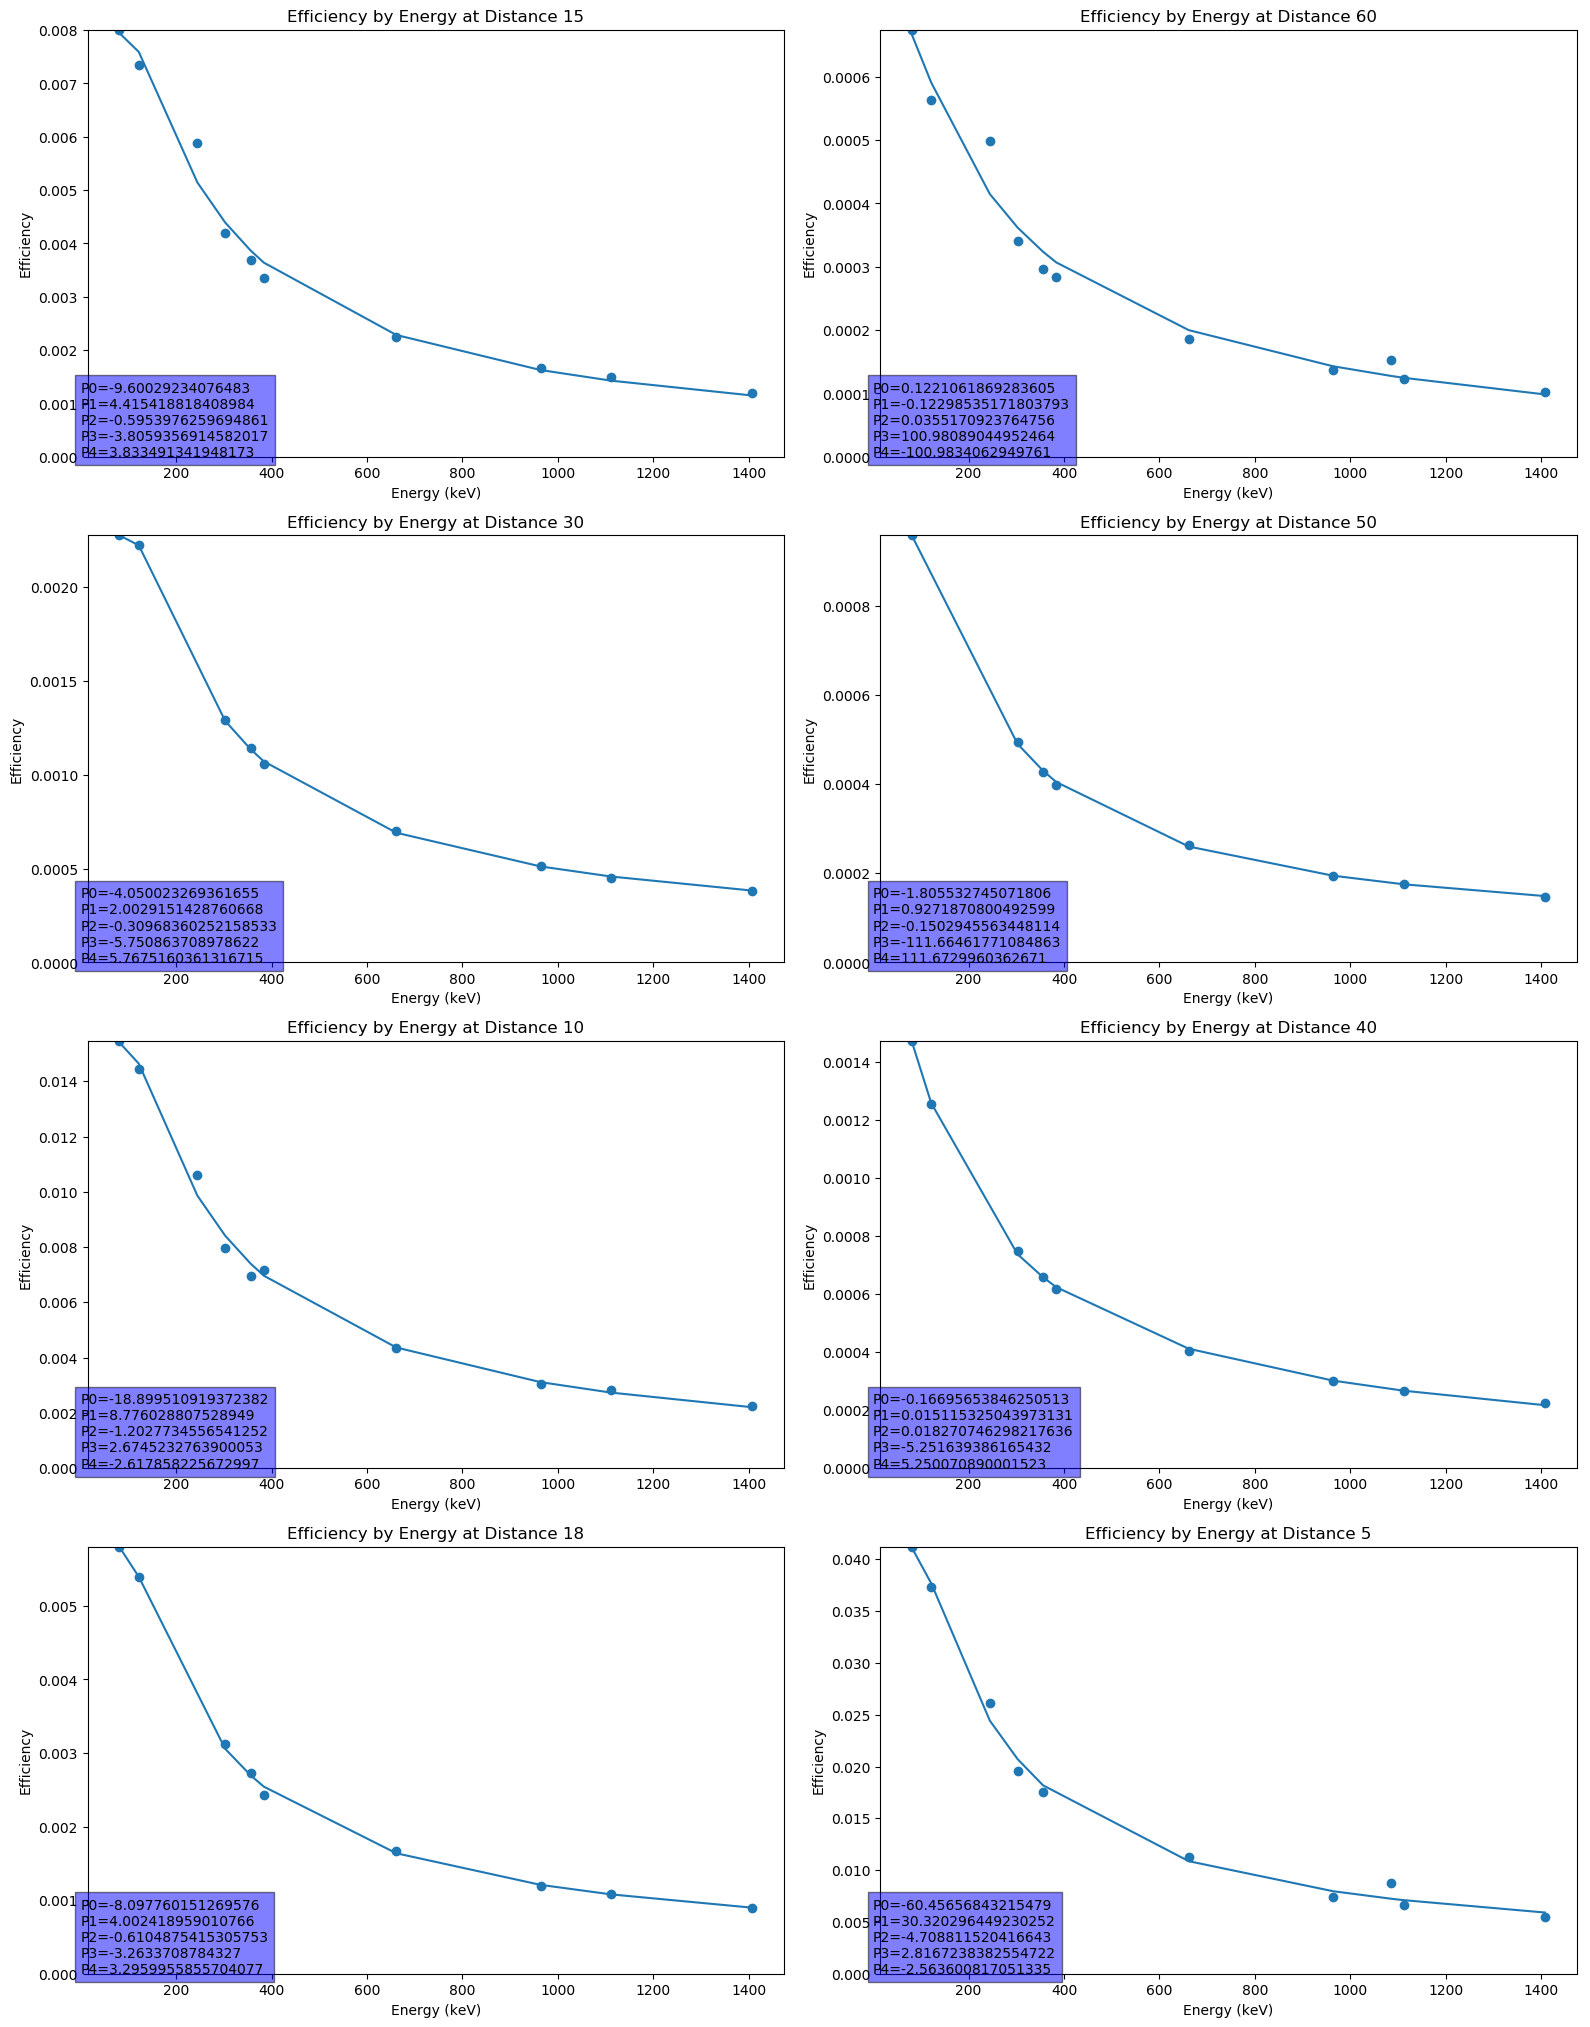

In [32]:
#plotting efficiency, determining curve based on sum of logs
plt.figure(figsize=(16,25),dpi=100)
sortedCalibrationEff=actualCalibrationEff.sort_values(by=['Energy'])

#record hpGe detector efficiency
geDetectorEfficiency=pd.DataFrame(columns=['distance','P0','P1','P2', 'P3','P4'])

for a in sourceDistance['distance']:
    plt.subplot(5,2,sourceDistance[sourceDistance['distance']==a].index.values.astype(int)[0]+1)
    x = np.array(sortedCalibrationEff['Energy'][sortedCalibrationEff['distance']==a].to_frame())
    y = np.array(sortedCalibrationEff['Efficiency'][sortedCalibrationEff['distance']==a].to_frame())
    plt.scatter(x, y, label='test')
    fit_params, pcov = scipy.optimize.curve_fit(SumOfLogs, x.ravel(), y.ravel())
    y_fit = SumOfLogs(x, *fit_params)
    maxEff=max(y)
    plt.plot(x, y_fit, label='Fit')
    #Add calculated values as text to plot 
    plt.text(0,0,'P0='+str(fit_params[0]) +'\nP1='+str(fit_params[1])+'\nP2='+str(fit_params[2])
             +'\nP3='+str(fit_params[3])+'\nP4='+str(fit_params[4]),bbox=dict(facecolor='blue', alpha=0.5))
    plt.xlabel('Energy (keV)')
    plt.ylim(0,maxEff)
    plt.ylabel('Efficiency')
    plt.title('Efficiency by Energy at Distance '+ str(a))
    geDetectorEfficiency=geDetectorEfficiency.append(
        {'distance':a,
         'P0':fit_params[0],
         'P1':fit_params[1],
         'P2':fit_params[2],
         'P3':fit_params[3],
         'P4':fit_params[4]
        },ignore_index=True)
plt.tight_layout()
geDetectorEfficiency




Text(0.5,1,'Efficiency by Energy at Distance')

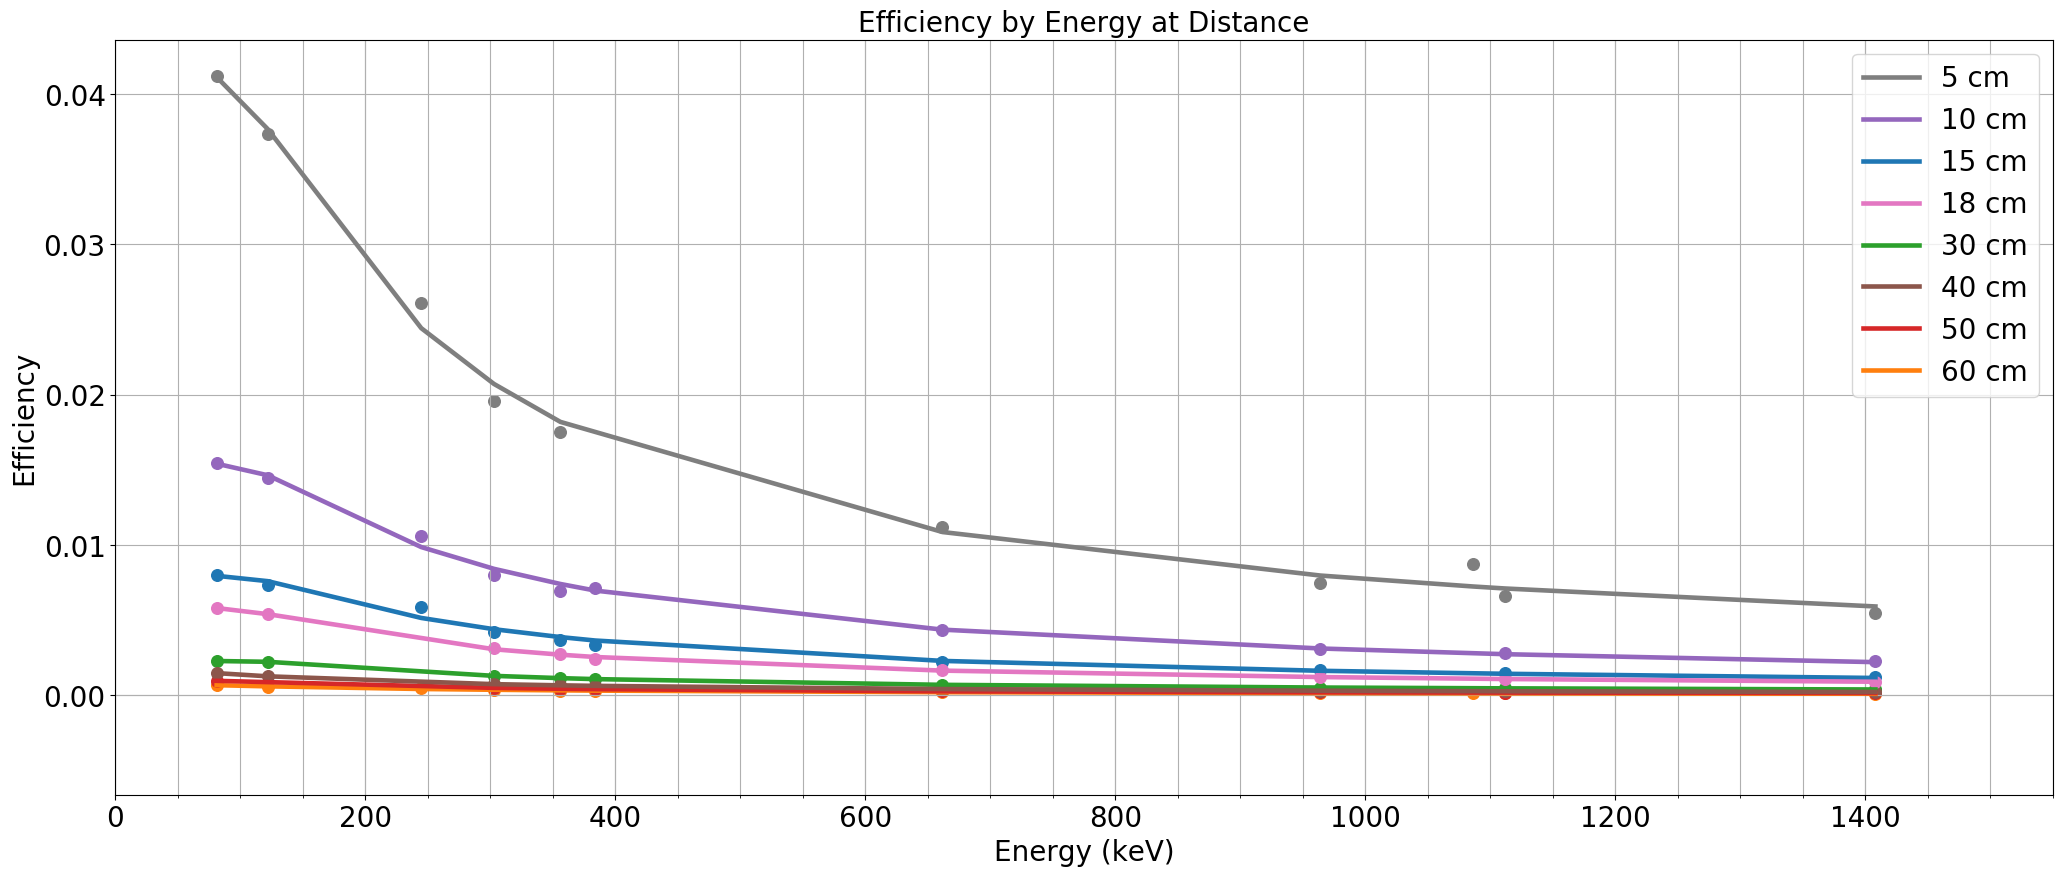

In [33]:
#plotting efficiency, determining curve based on sum of logs
fig=plt.figure(figsize=(25,10),dpi=100)
sortedCalibrationEff=actualCalibrationEff.sort_values(by=['Energy'])
ax = fig.add_subplot(1, 1, 1)

for a in sourceDistance['distance']:
    x = np.array(sortedCalibrationEff['Energy'][sortedCalibrationEff['distance']==a].to_frame())
    y = np.array(sortedCalibrationEff['Efficiency'][sortedCalibrationEff['distance']==a].to_frame())
    plt.scatter(x, y,s=70)
    fit_params, pcov = scipy.optimize.curve_fit(SumOfLogs, x.ravel(), y.ravel())
    y_fit = SumOfLogs(x, *fit_params)
    maxEff=max(y)
    plt.plot(x, y_fit, label=str(a) +" cm", linewidth=3.3)
    

# Major ticks every 20, minor ticks every 5
major_xticks = np.arange(0, 1600, 200)
minor_xticks = np.arange(0, 1600, 50)
major_yticks = np.arange(0, .05, .01)
minor_yticks = np.arange(0, .01, .02)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
ax.set_xticks(major_xticks)
ax.set_xticks(minor_xticks, minor=True)
ax.set_yticks(major_yticks)
ax.set_yticks(minor_yticks, minor=True)
ax.grid(which='both')
handles, labels = plt.gca().get_legend_handles_labels()
order = [7,4,0,6,2,5,3,1]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],prop={'size': 20})
#plt.legend(prop={'size': 20})
plt.xlabel('Energy (keV)')
plt.ylabel('Efficiency')
plt.title('Efficiency by Energy at Distance',fontsize=20)



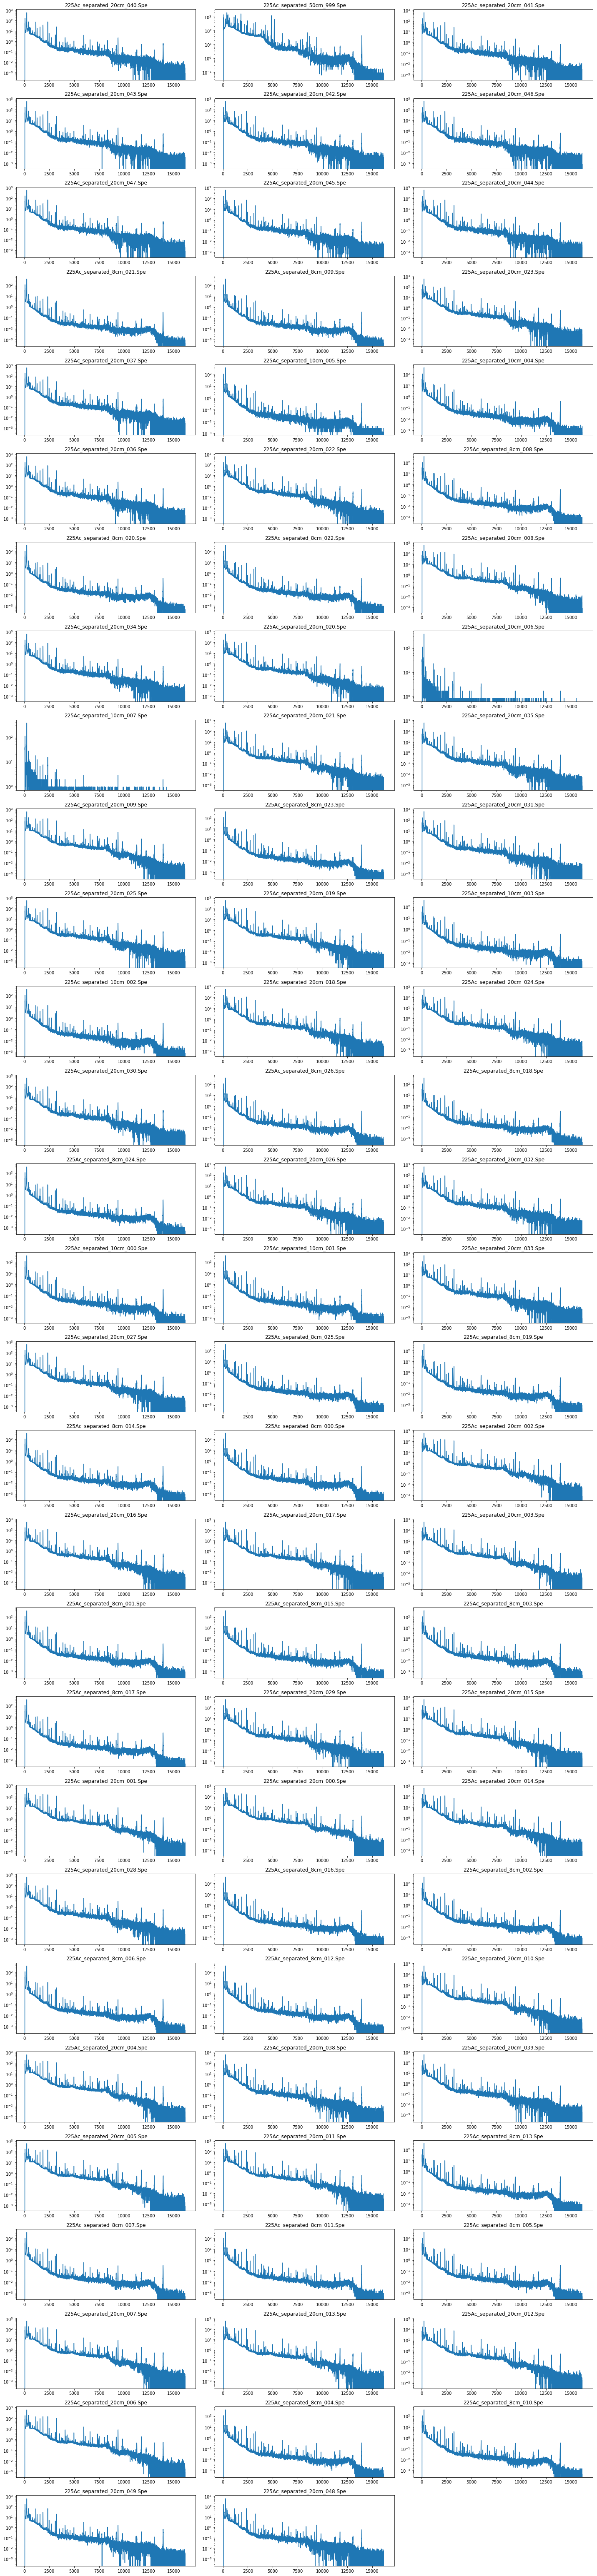

In [34]:
#**225Ac**
# subplots for each 225Ac file at distance
plt.figure(figsize=(20,len(dict225AcCount)))
i = 1
for name in keys225AcCount:
    plt.subplot(int(len(dict225AcCount)/3)+1,3,i)
    chan = np.linspace(1,len(dict225AcCount[name]), len(dict225AcCount[name]))
    #if 225Ac is >18 cm it is outside of the detector. we would need to subtract background radiation
    if dict225AcDistance[name]>18:
        plt.semilogy(chan, ((dict225AcCount[name]-backgroundDataByChanSec*dict225AcLiveTime[name])/percentDecays(dict225AcDistance[name])/dict225AcLiveTime[name]))
    else: plt.semilogy(chan, (dict225AcCount[name]/percentDecays(dict225AcDistance[name])/dict225AcLiveTime[name]))
    plt.plot()
    plt.title(name)
    i = i+1
plt.tight_layout()

In [35]:
# **FOILS**
#Init a dict for data, distance, foil type
dictFoilCount = {}
dictFoilDistance={}
dictFoilType={}
dictFoilStartTime={}
dictFoilLiveTime={}
dictFoilRealTime={}


# Loop through files, create pandas panda frame
for file in foilfiles:
    name = file.split('/')[3]
    df = pd.read_table(file)
    data  = np.array(df['$SPEC_ID:'][11:16395], dtype='float')
    distance=file[file.find('cm')-2:file.find('cm')]
    if name[9:13].find('_')==-1:
        foilType=name[9:13]
    else: foilType=name[9:12]
    dictFoilCount[name] = data
    dictFoilDistance[name]=int(distance)
    dictFoilType[name]=foilType
    dictFoilStartTime[name]=(df['$SPEC_ID:'][6])
    dictFoilLiveTime[name]= int(df['$SPEC_ID:'][8].split(' ')[0])
    dictFoilRealTime[name]= int(df['$SPEC_ID:'][8].split(' ')[1])
keysFoilCount = list(dictFoilCount.keys())


In [36]:
#**FOILS**
#data frame for foil characterization
foilCharacterization = pd.read_excel('foil_masses.xlsx')
foilReactions = pd.read_excel('FoilReactions.xlsx')
foilReactionData=pd.merge(foilCharacterization,foilReactions, on="Foil")
foilReactionData

,FoilID,Foil,mass,Order,Thickness,DistanceFromBeam,Reaction,Product,Half Life,Half Life (s),Gamma Energy [keV],Gamma Intensity [%]
0,In01,In,0.2869,5,0.50,2.28,"115In(n,p)115Cd",115Cd,44.6 d,3853440.0,933.8380,2.00
1,In01,In,0.2869,5,0.50,2.28,"115In(n,2n)114In'",114In',49.5 d,4276800.0,190.2700,15.60
2,In01,In,0.2869,5,0.50,2.28,"115In(n,2n)114In'",114In',49.5 d,4276800.0,558.4000,4.40
3,In01,In,0.2869,5,0.50,2.28,"115In(n,2n)114In'",114In',49.5 d,4276800.0,725.2400,4.40
4,In02,In,0.2877,6,0.50,2.78,"115In(n,p)115Cd",115Cd,44.6 d,3853440.0,933.8380,2.00
5,In02,In,0.2877,6,0.50,2.78,"115In(n,2n)114In'",114In',49.5 d,4276800.0,190.2700,15.60
6,In02,In,0.2877,6,0.50,2.78,"115In(n,2n)114In'",114In',49.5 d,4276800.0,558.4000,4.40
7,In02,In,0.2877,6,0.50,2.78,"115In(n,2n)114In'",114In',49.5 d,4276800.0,725.2400,4.40
8,Y01,Y,0.2700,3,0.64,1.00,"89Y(n,2n)88Y",88Y,106.6 d,9210240.0,898.0420,93.70
9,Y01,Y,0.2700,3,0.64,1.00,"89Y(n,2n)88Y",88Y,106.6 d,9210240.0,1836.0630,99.20


In [37]:
# #**FOILS**
# # subplots for each foil at distance
# plt.figure(figsize=(20,len(dictFoilCount)))
# i = 1
# for name in keysFoilCount:
#     if name.find('Y')!=-1:
#         plt.subplot(int(len(dictFoilCount)/3),3,i)
#         chan = np.linspace(1,len(dictFoilCount[name]), len(dictFoilCount[name]))
#         plt.semilogy(chan2E(chan), dictFoilCount[name])
#         plt.plot()
#         plt.title(name)
#         i = i+1
# plt.tight_layout()


In [38]:
##**time from beam stop to measurement date**
foilCalculations=pd.DataFrame(columns=['fileName','FoilType','Source','distance','measurementDatetime', 'elapsedTime','measurementRealTime','measurementLiveTime'])
for name in keysFoilCount:
    #time that source was measured
    measurementDatetime=datetime.strptime(dictFoilStartTime[name],'%m/%d/%Y %H:%M:%S')
    #time between end of beam time and measurement in seconds
    elapsedTime=(measurementDatetime-tstop).total_seconds()
    foilCalculations=foilCalculations.append(
        {'fileName':name,
         'FoilType':dictFoilType[name],
         'Source':dictFoilType[name][:-2],
         'distance':dictFoilDistance[name],
         'measurementDatetime':measurementDatetime,
         'elapsedTime':elapsedTime,
         'measurementRealTime':dictFoilRealTime[name],
         'measurementLiveTime':dictFoilLiveTime[name]
        },ignore_index=True)
foilCalculations

,fileName,FoilType,Source,distance,measurementDatetime,elapsedTime,measurementRealTime,measurementLiveTime
0,AN111218_Y02_60cm_003.Spe,Y02,Y,60,2018-11-14 17:08:01,623101.0,1852,1800
1,AQ111218_Ni01_60cm_027.Spe,Ni01,Ni,60,2018-11-19 03:52:01,1007341.0,2143,1800
2,AN111218_Y02_60cm_017.Spe,Y02,Y,60,2018-11-15 00:20:10,649030.0,1851,1800
3,AQ111218_Ni01_60cm_033.Spe,Ni01,Ni,60,2018-11-19 07:26:18,1020198.0,2142,1800
4,AL111218_Y01_60cm_041.Spe,Y01,Y,60,2018-11-14 13:59:29,611789.0,1972,1800
5,AO111218_In01_30cm_027.Spe,In01,In,30,2018-11-17 09:13:25,853825.0,2069,1800
6,AK111218_Zr01_70cm_018.Spe,Zr01,Zr,70,2018-11-13 01:10:01,479221.0,2019,1800
7,AK111218_Zr01_70cm_024.Spe,Zr01,Zr,70,2018-11-13 04:31:44,491324.0,2013,1800
8,AK111218_Zr01_70cm_030.Spe,Zr01,Zr,70,2018-11-13 07:52:48,503388.0,2006,1800
9,AM111218_Zr02_50cm_041.Spe,Zr02,Zr,50,2018-11-16 15:04:55,788515.0,1865,1800


In [39]:
#FOIL ACTIVITY
foilActivity=pd.merge(foilReactionData, foilCalculations, left_on='FoilID', right_on='FoilType', how='left')
#create channels array for length of data
channels=np.linspace(1,len(dictFoilCount[keysFoilCount[0]]),len(dictFoilCount[keysFoilCount[0]]))
#add measured relative activity field to calibrationEff
foilActivity['PeakCount'] = pd.Series([0 for x in range(len(foilActivity.index))], index=foilActivity.index)
foilActivity['ActivityA0'] = pd.Series([0 for x in range(len(foilActivity.index))], index=foilActivity.index)

#loop through distances and create energy arrays per distance
for i in sourceDistance['distance']:
    E=[]
    for a in range(0,len(dictFoilCount[keysFoilCount[0]])):
        E.append(float(chan2E(channels[a], i)))
    E = np.array(E)
    #loop through each row in calibrationEff. if the current row is the same as distance i, calculate the relative activity
    for j in foilActivity.index:
        
        if i!=(foilActivity['distance'].loc[j]):
            j+=1
            continue
        else:
            print(j)
            countUnderPeak=float(foilPeakCount(foilActivity['Gamma Energy [keV]'].iloc[j],str(foilActivity['fileName'].iloc[j]),E,"count"))
            #print(float(peakCount(calibrationEff['Energy'].iloc[j],str(calibrationEff['fileName'].iloc[j]),E,"count")))
            #relativeAtPerSecond=peakCount/float(calibrationEff['measurementTime'].iloc[j])
            if countUnderPeak<0:
                j+=1
                continue
            else:
                foilActivity['PeakCount'].iloc[j]=countUnderPeak
                a=detectorEfficiency(foilActivity['Gamma Energy [keV]'].iloc[j],i)
                print(a)
                foilActivity['ActivityA0'].iloc[j]=activityBeamStop(math.log(2)/float(foilActivity['Half Life (s)'].iloc[j]),
                    float(foilActivity['elapsedTime'].iloc[j]),
                    float(foilActivity['measurementLiveTime'].iloc[j]), 
                    float(foilActivity['measurementRealTime'].iloc[j]),
                    float(countUnderPeak),
                    float(detectorEfficiency(foilActivity['Gamma Energy [keV]'].iloc[j],i)),
                    float(foilActivity['Gamma Intensity [%]'].iloc[j]/100))
                j+=1    
            continue
#discard foil calculations where live time vs real time <90%
actualFoilActivity=foilActivity[foilActivity['measurementLiveTime']/foilActivity['measurementRealTime'] >= .9]
#export to Excel
pd.set_option('display.max_rows',1001)
writer=pd.ExcelWriter('output.xlsx')
actualFoilActivity.to_excel(writer,'sheet1')
writer.save()

170
calculated count for 933.838: 345.0
measured count for 933.838: -101.0
Value outside of range
217
calculated count for 190.27: 165847.0
measured count for 190.27: 159339.0
success on:  AG111218_In02_60cm.Spe
0.000479618569144941


/Users/Catherine/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



264
calculated count for 558.4: 20319.0
measured count for 558.4: 19620.0
success on:  AG111218_In02_60cm.Spe
0.00023014102479149457
311
calculated count for 725.24: 15976.0
measured count for 725.24: 15715.0
success on:  AG111218_In02_60cm.Spe
0.00018476492308385208
312
calculated count for 898.042: 573917.0
measured count for 898.042: 561422.0
success on:  AL111218_Y01_60cm_041.Spe
0.00015261672041795267
313
calculated count for 898.042: 573287.0
measured count for 898.042: 560518.0
success on:  AL111218_Y01_60cm_040.Spe
0.00015261672041795267
314
calculated count for 898.042: 574198.0
measured count for 898.042: 561654.0
success on:  AL111218_Y01_60cm_042.Spe
0.00015261672041795267
315
calculated count for 898.042: 494019.0
measured count for 898.042: 483538.0
success on:  AL111218_Y01_60cm_043.Spe
0.00015261672041795267
316
calculated count for 898.042: 574651.0
measured count for 898.042: 562255.0
success on:  AL111218_Y01_60cm_036.Spe
0.00015261672041795267
317
calculated count f

/Users/Catherine/anaconda3/lib/python3.7/site-packages/scipy/interpolate/fitpack2.py:226: UserWarning:


The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.



calculated count for 898.042: 575850.0
measured count for 898.042: 562834.0
success on:  AL111218_Y01_60cm_017.Spe
0.00015261672041795267
337
calculated count for 898.042: 576094.0
measured count for 898.042: 563403.0
success on:  AL111218_Y01_60cm_003.Spe
0.00015261672041795267
338
calculated count for 898.042: 577051.0
measured count for 898.042: 564434.0
success on:  AL111218_Y01_60cm_002.Spe
0.00015261672041795267
339
calculated count for 898.042: 575376.0
measured count for 898.042: 562765.0
success on:  AL111218_Y01_60cm_016.Spe
0.00015261672041795267
340
calculated count for 898.042: 578000.0
measured count for 898.042: 564953.0
success on:  AL111218_Y01_60cm_000.Spe
0.00015261672041795267
341
calculated count for 898.042: 577393.0
measured count for 898.042: 564464.0
success on:  AL111218_Y01_60cm_014.Spe
0.00015261672041795267
342
calculated count for 898.042: 575600.0
measured count for 898.042: 562601.0
success on:  AL111218_Y01_60cm_028.Spe
0.00015261672041795267
343
calcul

7.404317333802881e-05
394
calculated count for 1836.063: 344308.0
measured count for 1836.063: 340556.0
success on:  AL111218_Y01_60cm_010.Spe
7.404317333802881e-05
395
calculated count for 1836.063: 344709.0
measured count for 1836.063: 340831.0
success on:  AL111218_Y01_60cm_004.Spe
7.404317333802881e-05
396
calculated count for 1836.063: 344186.0
measured count for 1836.063: 340538.0
success on:  AL111218_Y01_60cm_038.Spe
7.404317333802881e-05
397
calculated count for 1836.063: 344033.0
measured count for 1836.063: 340240.0
success on:  AL111218_Y01_60cm_012.Spe
7.404317333802881e-05
398
calculated count for 1836.063: 344154.0
measured count for 1836.063: 340318.0
success on:  AL111218_Y01_60cm_006.Spe
7.404317333802881e-05
399
calculated count for 1836.063: 345072.0
measured count for 1836.063: 341388.0
success on:  AL111218_Y01_60cm_007.Spe
7.404317333802881e-05
400
calculated count for 1836.063: 344102.0
measured count for 1836.063: 340260.0
success on:  AL111218_Y01_60cm_013.Spe

0.0003042083589789072
473
calculated count for 388.5: 405032.0
measured count for 388.5: 371461.0
success on:  AL111218_Y01_60cm_002.Spe
0.0003042083589789072
474
calculated count for 388.5: 380164.0
measured count for 388.5: 347657.0
success on:  AL111218_Y01_60cm_016.Spe
0.0003042083589789072
475
calculated count for 388.5: 407112.0
measured count for 388.5: 373709.0
success on:  AL111218_Y01_60cm_000.Spe
0.0003042083589789072
476
calculated count for 388.5: 384532.0
measured count for 388.5: 352065.0
success on:  AL111218_Y01_60cm_014.Spe
0.0003042083589789072
477
calculated count for 388.5: 360525.0
measured count for 388.5: 328013.0
success on:  AL111218_Y01_60cm_028.Spe
0.0003042083589789072
478
calculated count for 388.5: 359337.0
measured count for 388.5: 320442.0
Measured values outside of range of calculated value. returning Calculated Value
0.0003042083589789072
479
calculated count for 388.5: 381935.0
measured count for 388.5: 348887.0
success on:  AL111218_Y01_60cm_015.Spe

calculated count for 484.8: 352489.0
measured count for 484.8: 325976.0
success on:  AL111218_Y01_60cm_012.Spe
0.00025748899841394456
533
calculated count for 484.8: 363185.0
measured count for 484.8: 336760.0
success on:  AL111218_Y01_60cm_006.Spe
0.00025748899841394456
534
calculated count for 484.8: 361808.0
measured count for 484.8: 335642.0
success on:  AL111218_Y01_60cm_007.Spe
0.00025748899841394456
535
calculated count for 484.8: 351099.0
measured count for 484.8: 320369.0
success on:  AL111218_Y01_60cm_013.Spe
0.00025748899841394456
536
calculated count for 484.8: 71430.0
measured count for 484.8: 67418.0
success on:  AC111218_Y01_60cm.Spe
0.00025748899841394456
537
calculated count for 898.042: 183034.0
measured count for 898.042: 180226.0
success on:  AN111218_Y02_60cm_003.Spe
0.00015261672041795267
538
calculated count for 898.042: 182483.0
measured count for 898.042: 179767.0
success on:  AN111218_Y02_60cm_017.Spe
0.00015261672041795267
539
calculated count for 898.042: 18

calculated count for 1836.063: 108591.0
measured count for 1836.063: 107801.0
success on:  AN111218_Y02_60cm_028.Spe
7.404317333802881e-05
593
calculated count for 1836.063: 109210.0
measured count for 1836.063: 108299.0
success on:  AN111218_Y02_60cm_014.Spe
7.404317333802881e-05
594
calculated count for 1836.063: 108986.0
measured count for 1836.063: 108175.0
success on:  AN111218_Y02_60cm_000.Spe
7.404317333802881e-05
595
calculated count for 1836.063: 109373.0
measured count for 1836.063: 108577.0
success on:  AN111218_Y02_60cm_001.Spe
7.404317333802881e-05
596
calculated count for 1836.063: 108504.0
measured count for 1836.063: 107745.0
success on:  AN111218_Y02_60cm_015.Spe
7.404317333802881e-05
597
calculated count for 1836.063: 108968.0
measured count for 1836.063: 108054.0
success on:  AN111218_Y02_60cm_029.Spe
7.404317333802881e-05
598
calculated count for 1836.063: 109369.0
measured count for 1836.063: 108579.0
success on:  AN111218_Y02_60cm_011.Spe
7.404317333802881e-05
599

calculated count for 1077.0: 1389.0
measured count for 1077.0: 107.0
Value outside of range
658
calculated count for 1077.0: 7271.0
measured count for 1077.0: -94.0
Value outside of range
659
calculated count for 1077.0: 7205.0
measured count for 1077.0: 16.999999999996362
Value outside of range
660
calculated count for 1077.0: 7015.0
measured count for 1077.0: 957.0
Value outside of range
661
calculated count for 1077.0: 7267.0
measured count for 1077.0: 773.0
Value outside of range
662
calculated count for 1077.0: 7101.0
measured count for 1077.0: 384.0
Value outside of range
663
calculated count for 1077.0: 7231.0
measured count for 1077.0: 309.0
Value outside of range
664
calculated count for 1077.0: 7217.0
measured count for 1077.0: 1185.0
Value outside of range
665
calculated count for 1077.0: 7061.0
measured count for 1077.0: -114.0
Value outside of range
666
calculated count for 1077.0: 7152.0
measured count for 1077.0: 150.0
Value outside of range
667
calculated count for 1077

721
calculated count for 388.5: 89915.0
measured count for 388.5: 80284.0
Measured values outside of range of calculated value. returning Calculated Value
0.0003042083589789072
722
calculated count for 388.5: 85579.0
measured count for 388.5: 76007.0
Measured values outside of range of calculated value. returning Calculated Value
0.0003042083589789072
723
calculated count for 388.5: 84949.0
measured count for 388.5: 75247.0
Measured values outside of range of calculated value. returning Calculated Value
0.0003042083589789072
724
calculated count for 388.5: 89571.0
measured count for 388.5: 77536.0
Measured values outside of range of calculated value. returning Calculated Value
0.0003042083589789072
725
calculated count for 388.5: 95466.0
measured count for 388.5: 85936.0
success on:  AN111218_Y02_60cm_009.Spe
0.0003042083589789072
726
calculated count for 388.5: 85507.0
measured count for 388.5: 75821.0
Measured values outside of range of calculated value. returning Calculated Value
0.

0.00025748899841394456
772
calculated count for 484.8: 82560.0
measured count for 484.8: 74817.0
success on:  AN111218_Y02_60cm_022.Spe
0.00025748899841394456
773
calculated count for 484.8: 78097.0
measured count for 484.8: 70441.0
success on:  AN111218_Y02_60cm_036.Spe
0.00025748899841394456
774
calculated count for 484.8: 77867.0
measured count for 484.8: 68369.0
Measured values outside of range of calculated value. returning Calculated Value
0.00025748899841394456
775
calculated count for 484.8: 81664.0
measured count for 484.8: 74002.0
success on:  AN111218_Y02_60cm_023.Spe
0.00025748899841394456
776
calculated count for 484.8: 86898.0
measured count for 484.8: 79061.0
success on:  AN111218_Y02_60cm_009.Spe
0.00025748899841394456
777
calculated count for 484.8: 78447.0
measured count for 484.8: 69281.0
Measured values outside of range of calculated value. returning Calculated Value
0.00025748899841394456
778
calculated count for 484.8: 82815.0
measured count for 484.8: 73459.0
Mea

0.00016745369844697232
828
calculated count for 810.7593: 1724475.0
measured count for 810.7593: 1702853.0
success on:  AQ111218_Ni01_60cm_028.Spe
0.00016745369844697232
829
calculated count for 810.7593: 1727652.0
measured count for 810.7593: 1706211.0
success on:  AQ111218_Ni01_60cm_029.Spe
0.00016745369844697232
830
calculated count for 810.7593: 1735443.0
measured count for 810.7593: 1713228.0
success on:  AQ111218_Ni01_60cm_001.Spe
0.00016745369844697232
831
calculated count for 810.7593: 1732665.0
measured count for 810.7593: 1710538.0
success on:  AQ111218_Ni01_60cm_015.Spe
0.00016745369844697232
832
calculated count for 810.7593: 1738800.0
measured count for 810.7593: 1716825.0
success on:  AQ111218_Ni01_60cm_003.Spe
0.00016745369844697232
833
calculated count for 810.7593: 1730258.0
measured count for 810.7593: 1708708.0
success on:  AQ111218_Ni01_60cm_017.Spe
0.00016745369844697232
834
calculated count for 810.7593: 1729929.0
measured count for 810.7593: 1708031.0
success on:

0.00016745369844697232
885
calculated count for 810.7593: 521140.0
measured count for 810.7593: 518163.0
success on:  AR111218_Ni02_60cm_044.Spe
0.00016745369844697232
1015
calculated count for 909.15: 1180611.0
measured count for 909.15: 1174459.0
success on:  AD111218_Zr02_60cm.Spe
0.0001508987245929803
1061
calculated count for 392.87: 191288.0
measured count for 392.87: 17723.0
Value outside of range
0
failure on:  AO111218_In01_30cm_027.Spe
1
failure on:  AO111218_In01_30cm_026.Spe
2
failure on:  AO111218_In01_30cm_018.Spe
3
failure on:  AO111218_In01_30cm_024.Spe
4
failure on:  AO111218_In01_30cm_025.Spe
5
failure on:  AO111218_In01_30cm_019.Spe
6
calculated count for 933.838: 12055.0
measured count for 933.838: 507.0
Value outside of range
7
failure on:  AO111218_In01_30cm_009.Spe
8
calculated count for 933.838: 11994.0
measured count for 933.838: -354.0
Value outside of range
9
failure on:  AO111218_In01_30cm_020.Spe
10
calculated count for 933.838: 12045.0
measured count for 9

0.0007932781360733983
75
calculated count for 558.4: 264975.0
measured count for 558.4: 244626.0
success on:  AO111218_In01_30cm_012.Spe
0.0007932781360733983
76
calculated count for 558.4: 264704.0
measured count for 558.4: 244408.0
success on:  AO111218_In01_30cm_006.Spe
0.0007932781360733983
77
calculated count for 558.4: 264364.0
measured count for 558.4: 243929.0
success on:  AO111218_In01_30cm_007.Spe
0.0007932781360733983
78
calculated count for 558.4: 264393.0
measured count for 558.4: 244068.0
success on:  AO111218_In01_30cm_013.Spe
0.0007932781360733983
79
calculated count for 558.4: 265753.0
measured count for 558.4: 245705.0
success on:  AO111218_In01_30cm_005.Spe
0.0007932781360733983
80
calculated count for 558.4: 264747.0
measured count for 558.4: 244209.0
success on:  AO111218_In01_30cm_011.Spe
0.0007932781360733983
81
calculated count for 558.4: 265397.0
measured count for 558.4: 245200.0
success on:  AO111218_In01_30cm_010.Spe
0.0007932781360733983
82
calculated count

calculated count for 933.838: 3640.0
measured count for 933.838: 101.0
Value outside of range
151
calculated count for 933.838: 3674.0
measured count for 933.838: -71.0
Value outside of range
152
calculated count for 933.838: 3565.0
measured count for 933.838: -202.0
Value outside of range
153
calculated count for 933.838: 3672.0
measured count for 933.838: -274.0
Value outside of range
154
calculated count for 933.838: 3638.0
measured count for 933.838: 23.0
Value outside of range
155
calculated count for 933.838: 3617.0
measured count for 933.838: -156.0
Value outside of range
156
calculated count for 933.838: 3691.0
measured count for 933.838: 116.0
Value outside of range
157
calculated count for 933.838: 3662.0
measured count for 933.838: -51.0
Value outside of range
158
calculated count for 933.838: 3701.0
measured count for 933.838: -23.0
Value outside of range
159
calculated count for 933.838: 3615.0
measured count for 933.838: 56.00000000000182
Value outside of range
160
calcul

0.0017820527199900926
216
calculated count for 190.27: 712348.0
measured count for 190.27: 694611.0
success on:  AP111218_In02_30cm_039.Spe
0.0017820527199900926
218
calculated count for 558.4: 86835.0
measured count for 558.4: 81061.0
success on:  AP111218_In02_30cm_043.Spe
0.0007932781360733983
219
calculated count for 558.4: 86821.0
measured count for 558.4: 82551.0
success on:  AP111218_In02_30cm_042.Spe
0.0007932781360733983
220
calculated count for 558.4: 86929.0
measured count for 558.4: 81216.0
success on:  AP111218_In02_30cm_040.Spe
0.0007932781360733983
221
calculated count for 558.4: 86390.0
measured count for 558.4: 81835.0
success on:  AP111218_In02_30cm_041.Spe
0.0007932781360733983
222
calculated count for 558.4: 85678.0
measured count for 558.4: 81156.0
success on:  AP111218_In02_30cm_045.Spe
0.0007932781360733983
223
calculated count for 558.4: 86423.0
measured count for 558.4: 81898.0
success on:  AP111218_In02_30cm_044.Spe
0.0007932781360733983
224
calculated count f

279
calculated count for 725.24: 68837.0
measured count for 725.24: 65382.0
success on:  AP111218_In02_30cm_022.Spe
0.000642061669049911
280
calculated count for 725.24: 68684.0
measured count for 725.24: 65741.0
success on:  AP111218_In02_30cm_036.Spe
0.000642061669049911
281
calculated count for 725.24: 68599.0
measured count for 725.24: 65647.0
success on:  AP111218_In02_30cm_032.Spe
0.000642061669049911
282
calculated count for 725.24: 68614.0
measured count for 725.24: 65291.0
success on:  AP111218_In02_30cm_026.Spe
0.000642061669049911
283
calculated count for 725.24: 69308.0
measured count for 725.24: 66468.0
success on:  AP111218_In02_30cm_027.Spe
0.000642061669049911
284
calculated count for 725.24: 68447.0
measured count for 725.24: 65643.0
success on:  AP111218_In02_30cm_033.Spe
0.000642061669049911
285
calculated count for 725.24: 69149.0
measured count for 725.24: 66569.0
success on:  AP111218_In02_30cm_019.Spe
0.000642061669049911
286
calculated count for 725.24: 68789.0


0.00020316143066711746
1002
calculated count for 909.15: 422079.0
measured count for 909.15: 419658.0
success on:  AM111218_Zr02_50cm_002.Spe
0.00020316143066711746
1003
calculated count for 909.15: 399891.0
measured count for 909.15: 397588.0
success on:  AM111218_Zr02_50cm_014.Spe
0.00020316143066711746
1004
calculated count for 909.15: 426052.0
measured count for 909.15: 423455.0
success on:  AM111218_Zr02_50cm_000.Spe
0.00020316143066711746
1005
calculated count for 909.15: 374823.0
measured count for 909.15: 372639.0
success on:  AM111218_Zr02_50cm_028.Spe
0.00020316143066711746
1006
calculated count for 909.15: 373281.0
measured count for 909.15: 370930.0
success on:  AM111218_Zr02_50cm_029.Spe
0.00020316143066711746
1007
calculated count for 909.15: 424973.0
measured count for 909.15: 422048.0
success on:  AM111218_Zr02_50cm_001.Spe
0.00020316143066711746
1008
calculated count for 909.15: 397564.0
measured count for 909.15: 395014.0
success on:  AM111218_Zr02_50cm_015.Spe
0.0002

In [40]:
#Reaction Rate based on irradiation time
def ReactionRate(ActivityT, varlambda, time):
    return ActivityT/(1-math.e**(-varlambda*time))

In [41]:
#REACTION RATE OF FOILS
foilActivity['ReactionRate'] = pd.Series([0 for x in range(len(foilActivity.index))], index=foilActivity.index)
for j in foilActivity.index:
    foilActivity['ReactionRate'].iloc[j]=float(ReactionRate(foilActivity['ActivityA0'].iloc[j],
        math.log(2)/float(foilActivity['Half Life (s)'].iloc[j]),tBeamTime))
    
foilActivity
        



/Users/Catherine/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,FoilID,Foil,mass,Order,Thickness,DistanceFromBeam,Reaction,Product,Half Life,Half Life (s),...,FoilType,Source,distance,measurementDatetime,elapsedTime,measurementRealTime,measurementLiveTime,PeakCount,ActivityA0,ReactionRate
0,In01,In,0.2869,5,0.50,2.28,"115In(n,p)115Cd",115Cd,44.6 d,3853440.0,...,In01,In,30,2018-11-17 09:13:25,853825.0,2069,1800,0.0,0.000000e+00,0.000000e+00
1,In01,In,0.2869,5,0.50,2.28,"115In(n,p)115Cd",115Cd,44.6 d,3853440.0,...,In01,In,30,2018-11-17 08:38:55,851755.0,2069,1800,0.0,0.000000e+00,0.000000e+00
2,In01,In,0.2869,5,0.50,2.28,"115In(n,p)115Cd",115Cd,44.6 d,3853440.0,...,In01,In,30,2018-11-17 04:02:52,835192.0,2070,1800,0.0,0.000000e+00,0.000000e+00
3,In01,In,0.2869,5,0.50,2.28,"115In(n,p)115Cd",115Cd,44.6 d,3853440.0,...,In01,In,30,2018-11-17 07:29:55,847615.0,2069,1800,0.0,0.000000e+00,0.000000e+00
4,In01,In,0.2869,5,0.50,2.28,"115In(n,p)115Cd",115Cd,44.6 d,3853440.0,...,In01,In,30,2018-11-17 08:04:25,849685.0,2069,1800,0.0,0.000000e+00,0.000000e+00
5,In01,In,0.2869,5,0.50,2.28,"115In(n,p)115Cd",115Cd,44.6 d,3853440.0,...,In01,In,30,2018-11-17 04:37:23,837263.0,2070,1800,0.0,0.000000e+00,0.000000e+00
6,In01,In,0.2869,5,0.50,2.28,"115In(n,p)115Cd",115Cd,44.6 d,3853440.0,...,In01,In,30,2018-11-17 05:46:25,841405.0,2070,1800,0.0,0.000000e+00,0.000000e+00
7,In01,In,0.2869,5,0.50,2.28,"115In(n,p)115Cd",115Cd,44.6 d,3853440.0,...,In01,In,30,2018-11-16 22:52:07,816547.0,2072,1800,0.0,0.000000e+00,0.000000e+00
8,In01,In,0.2869,5,0.50,2.28,"115In(n,p)115Cd",115Cd,44.6 d,3853440.0,...,In01,In,30,2018-11-16 22:17:35,814475.0,2072,1800,0.0,0.000000e+00,0.000000e+00
9,In01,In,0.2869,5,0.50,2.28,"115In(n,p)115Cd",115Cd,44.6 d,3853440.0,...,In01,In,30,2018-11-17 05:11:54,839334.0,2070,1800,0.0,0.000000e+00,0.000000e+00


In [42]:
##**time from beam stop to measurement date**
AcCalculations=pd.DataFrame(columns=['fileName','distance','measurementDatetime', 'elapsedTime','measurementRealTime','measurementLiveTime'])
for name in keys225AcCount:
    #time that source was measured
    measurementDatetime=datetime.strptime(dict225AcStartTime[name],'%m/%d/%Y %H:%M:%S')
    #time between end of beam time and measurement in seconds
    elapsedTime=(measurementDatetime-tstop).total_seconds()
    AcCalculations=AcCalculations.append(
        {'fileName':name,
         'distance':dict225AcDistance[name],
         'measurementDatetime':measurementDatetime,
         'elapsedTime':elapsedTime,
         'measurementRealTime':dict225AcRealTime[name],
         'measurementLiveTime':dict225AcLiveTime[name]
        },ignore_index=True)
AcCalculations

,fileName,distance,measurementDatetime,elapsedTime,measurementRealTime,measurementLiveTime
0,225Ac_separated_20cm_040.Spe,20,2018-12-03 00:54:39,2206299.0,21723.0,21600.0
1,225Ac_separated_50cm_999.Spe,50,2018-11-20 16:04:42,1137702.0,4801.0,4669.0
2,225Ac_separated_20cm_041.Spe,20,2018-12-03 06:56:41,2228021.0,21721.0,21600.0
3,225Ac_separated_20cm_043.Spe,20,2018-12-03 19:00:40,2271460.0,21718.0,21600.0
4,225Ac_separated_20cm_042.Spe,20,2018-12-03 12:58:41,2249741.0,21720.0,21600.0
5,225Ac_separated_20cm_046.Spe,20,2018-12-04 13:06:28,2336608.0,21714.0,21600.0
6,225Ac_separated_20cm_047.Spe,20,2018-12-04 19:08:21,2358321.0,21713.0,21600.0
7,225Ac_separated_20cm_045.Spe,20,2018-12-04 07:04:33,2314893.0,21715.0,21600.0
8,225Ac_separated_20cm_044.Spe,20,2018-12-04 01:02:37,2293177.0,21717.0,21600.0
9,225Ac_separated_8cm_021.Spe,8,2018-12-26 18:38:12,4257312.0,21817.0,21600.0


In [45]:
##225Ac PEAK FITTING
#function takes in the peak energy, filename, array of energies, and type of calculation to return (gaussian dist. vs actual count under peak less background)
#return type functionality not built out yet. inputs will be "count" to return the counts under the peak or "gaussian" to return the calculated area under a fitted gaussian distribution
def AcpeakCount(peakValue, name,E,returnType,dist):
    try:
        name=str(name)
        
        distance=dist

        numSearchEnergy=10
        # define a starting range
        peakChannel=E2chan(peakValue, distance)
        channels=np.linspace(1,len(dict225AcCount[keys225AcCount[0]]),len(dict225AcCount[keys225AcCount[0]]))
        r0 = np.min(np.where(E > peakValue-numSearchEnergy)[0])
        r1 = np.max(np.where(E < peakValue+numSearchEnergy)[0])
        r0,r1

        # define initially ranged channels and energy arrays
        channelsTrim = channels[r0:r1]
        ETrim = E[r0:r1]

        # Init dict of TotCount 
        dictTotCountPerChan = {}
        dictTotCountPerE = {}
        dictSigma = {}
        dictMaxE = {}
        dictMaxCount = {}

        # Get Count data within Range
        
        rangedCount = dict225AcCount[name][r0:r1]

        # Find Peaks
        peaks = signal.find_peaks(rangedCount, distance = 1000)[0]

        # Spline!
        spl = UnivariateSpline(ETrim,rangedCount)

        # Spline to find sigma and roots
        spl2 = UnivariateSpline(ETrim,rangedCount-np.max(rangedCount/2))
        rootCalc = spl2.roots()
        roots = np.array([rootCalc[0], rootCalc[-1]])
        sigma = np.mean([np.absolute(ETrim[peaks[0]]-roots[0]), np.absolute(ETrim[peaks[0]]-roots[-1])])


        # Integrate over spline from 3*sigma to get total count per E
        totCountPerE = spl.integral(roots[0]-sigma*3, roots[-1]+sigma*3)

        #calculate sigma in terms of channel
        sigmaChan=E2chan(sigma,distance)

        #get counts within 3sigma channels
        totCountPerEMeasured=0
        for y in range(int(r0+peaks[0]-round(sigmaChan*3)),int(r0+peaks[0]+round(sigmaChan*3))):
            totCountPerEMeasured+=dict225AcCount[name][y]
            y+=1
      

        # Convert calculated count related to E to calculated count related to chan
        totCountPerChanCalc = round(E2chan(totCountPerE,distance))

        # count background around peak
        lowerBoundCount=0
        upperBoundCount=0
        for a in range(int(r0+peaks[0]-round(sigmaChan*4)),int(r0+peaks[0]-round(sigmaChan*3))):
            lowerBoundCount+=dict225AcCount[name][a]
            a+=1
        for b in range(int(r0+peaks[0]+round(sigmaChan*3)),int(r0+peaks[0]+round(sigmaChan*4))):
            upperBoundCount+=dict225AcCount[name][b]
            b+=1
        
        #calculate average background per channel on either side of peak
        backgroundperChan=(lowerBoundCount+upperBoundCount)/(2*sigmaChan)
        totCountPerChanMeas=totCountPerEMeasured-backgroundperChan*6*sigmaChan
        print("calculated count for " + str(peakValue) +": "+ str(totCountPerChanCalc.values[0]))
        print("measured count for " + str(peakValue) +": "+str(totCountPerChanMeas.values[0]))
        return (totCountPerChanMeas,totCountPerChanCalc )

    except IndexError:
        print("failure on: ",name)
        return -1
    except TypeError:
        print("failure on: ",name)
        return -1

In [57]:
#225Ac ACTIVITY
#create channels array for length of data
channels=np.linspace(1,len(dict225AcCount[keys225AcCount[0]]),len(dict225AcCount[keys225AcCount[0]]))

AcCalculations['PeakCount'] = pd.Series([0 for x in range(len(AcCalculations.index))], index=AcCalculations.index)
AcCalculations['PeakCalc'] = pd.Series([0 for x in range(len(AcCalculations.index))], index=AcCalculations.index)
AcCalculations['Efficiency'] = pd.Series([0 for x in range(len(AcCalculations.index))], index=AcCalculations.index)
AcCalculations['ActivityAtCount'] = pd.Series([0 for x in range(len(AcCalculations.index))], index=AcCalculations.index)
AcCalculations['ActivityAtCalc'] = pd.Series([0 for x in range(len(AcCalculations.index))], index=AcCalculations.index)
AcCalculations['TimeFromSeparation'] = pd.Series([0 for x in range(len(AcCalculations.index))], index=AcCalculations.index)


#loop through distances and create energy arrays per distance
for i in sourceDistance['distance']:
    E=[]
    for a in range(0,len(dict225AcCount[keys225AcCount[0]])):
        E.append(float(chan2E(channels[a], i)))
    E = np.array(E)
    #loop through each row in calibrationEff. if the current row is the same as distance i, calculate the relative activity
    for j in AcCalculations.index:
        countUnderPeak=[0,0]
        #distances of 8cm, 20cm not done
        if i not in range(AcCalculations['distance'].loc[j]-2,AcCalculations['distance'].loc[j]+2):
            j+=1
            continue
        else:
            countUnderPeak=AcpeakCount(441,str(AcCalculations['fileName'].iloc[j]),E,"count",i)

            if float(countUnderPeak[0])<10000:
                j+=1
                continue
            else:
                print(j,countUnderPeak[0],countUnderPeak[1])
                AcCalculations['PeakCount'].iloc[j]=float(countUnderPeak[0])
                AcCalculations['PeakCalc'].iloc[j]=float(countUnderPeak[1])
                AcCalculations['Efficiency'].iloc[j]=detectorEfficiency(np.array([441]),i)
                AcCalculations['ActivityAtCount'].iloc[j]=activityBeamStop(math.log(2)/float(10*24*3600),
                    1,
                    float(AcCalculations['measurementLiveTime'].iloc[j]), 
                    float(AcCalculations['measurementRealTime'].iloc[j]),
                    float(countUnderPeak[0]),
                    float(detectorEfficiency(np.array([441]),i)),
                    #intensity of 25.94
                    .2594)
                AcCalculations['ActivityAtCalc'].iloc[j]=activityBeamStop(math.log(2)/float(10*24*3600),
                    1,
                    float(AcCalculations['measurementLiveTime'].iloc[j]), 
                    float(AcCalculations['measurementRealTime'].iloc[j]),
                    float(countUnderPeak[1]),
                    float(detectorEfficiency(np.array([441]),i)),
                    #intensity of 25.94
                    .2594)
                #print(AcCalculations['measurementLiveTime'])
                #print(type(AcCalculations['measurementLiveTime'].iloc[j]))
                AcCalculations['TimeFromSeparation'].iloc[j]=(datetime.strptime(str(AcCalculations['measurementDatetime'].iloc[j]),'%Y-%m-%d %H:%M:%S')-tseparation).total_seconds()
                j+=1    
            continue
AcCalculations
 #discard foil calculations where live time vs real time <90%
AcCalculations1=AcCalculations[AcCalculations['measurementLiveTime']/AcCalculations['measurementRealTime'] >= .9]
AcCalculations1=AcCalculations1[AcCalculations1['ActivityAtCount']>0]
AcCalculations1
#export to Excel
pd.set_option('display.max_rows',1001)
writer=pd.ExcelWriter('output.xlsx')
AcCalculations1.to_excel(writer,'sheet1')
writer.save()

calculated count for 441: 39976.0
measured count for 441: 17007.0
1 6    17007.0
dtype: float64 6    39976.0
dtype: float64


/Users/Catherine/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



calculated count for 441: 77205.0
measured count for 441: 74164.0
13 1    74164.0
dtype: float64 1    77205.0
dtype: float64
calculated count for 441: 140899.0
measured count for 441: 135355.0
14 1    135355.0
dtype: float64 1    140899.0
dtype: float64
calculated count for 441: 151.0
measured count for 441: 142.0
calculated count for 441: 124.0
measured count for 441: 117.0
calculated count for 441: 142908.0
measured count for 441: 138608.0
32 1    138608.0
dtype: float64 1    142908.0
dtype: float64
calculated count for 441: 145867.0
measured count for 441: 141394.0
33 1    141394.0
dtype: float64 1    145867.0
dtype: float64
calculated count for 441: 151222.0
measured count for 441: 146784.0
42 1    146784.0
dtype: float64 1    151222.0
dtype: float64
calculated count for 441: 149132.0
measured count for 441: 144801.0
43 1    144801.0
dtype: float64 1    149132.0
dtype: float64
calculated count for 441: 207615.0
measured count for 441: 200997.0
0 3    200997.0
dtype: float64 3    20

/Users/Catherine/anaconda3/lib/python3.7/site-packages/scipy/interpolate/fitpack2.py:226: UserWarning:


The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.



calculated count for 441: 378153.0
measured count for 441: 360261.0
78 3    360261.0
dtype: float64 3    378153.0
dtype: float64
calculated count for 441: 338283.0
measured count for 441: 323976.0
79 3    323976.0
dtype: float64 3    338283.0
dtype: float64
calculated count for 441: 345074.0
measured count for 441: 330100.0
80 3    330100.0
dtype: float64 3    345074.0
dtype: float64
calculated count for 441: 384939.0
measured count for 441: 365968.0
81 3    365968.0
dtype: float64 3    384939.0
dtype: float64
calculated count for 441: 177066.0
measured count for 441: 171807.0
84 3    171807.0
dtype: float64 3    177066.0
dtype: float64
calculated count for 441: 180819.0
measured count for 441: 176618.0
85 3    176618.0
dtype: float64 3    180819.0
dtype: float64


In [58]:
AcCalculations1

,fileName,distance,measurementDatetime,elapsedTime,measurementRealTime,measurementLiveTime,PeakCount,PeakCalc,Efficiency,ActivityAtCount,ActivityAtCalc,TimeFromSeparation
0,225Ac_separated_20cm_040.Spe,20,2018-12-03 00:54:39,2206299.0,21723.0,21600.0,200997.0,207615.0,0.002276,15897.937986,16421.391339,1090479.0
1,225Ac_separated_50cm_999.Spe,50,2018-11-20 16:04:42,1137702.0,4801.0,4669.0,17007.0,39976.0,0.000361,38960.256865,91578.481122,21882.0
2,225Ac_separated_20cm_041.Spe,20,2018-12-03 06:56:41,2228021.0,21721.0,21600.0,198359.0,204822.0,0.002276,15689.271772,16200.464929,1112201.0
3,225Ac_separated_20cm_043.Spe,20,2018-12-03 19:00:40,2271460.0,21718.0,21600.0,192027.0,1024491.0,0.002276,15188.421880,81032.362740,1155640.0
4,225Ac_separated_20cm_042.Spe,20,2018-12-03 12:58:41,2249741.0,21720.0,21600.0,195004.0,201212.0,0.002276,15423.900751,15914.924401,1133921.0
5,225Ac_separated_20cm_046.Spe,20,2018-12-04 13:06:28,2336608.0,21714.0,21600.0,181829.0,187512.0,0.002276,14381.785601,14831.283138,1220788.0
6,225Ac_separated_20cm_047.Spe,20,2018-12-04 19:08:21,2358321.0,21713.0,21600.0,178314.0,183732.0,0.002276,14103.760632,14532.297792,1242501.0
7,225Ac_separated_20cm_045.Spe,20,2018-12-04 07:04:33,2314893.0,21715.0,21600.0,183630.0,189871.0,0.002276,14524.241712,15017.874520,1199073.0
8,225Ac_separated_20cm_044.Spe,20,2018-12-04 01:02:37,2293177.0,21717.0,21600.0,189756.0,194319.0,0.002276,15008.790584,15369.702025,1177357.0
11,225Ac_separated_20cm_023.Spe,20,2018-11-28 18:14:25,1836685.0,21763.0,21600.0,271212.0,281354.0,0.002276,21451.964647,22254.163021,720865.0


In [59]:
#activity at time n
def activityNopt(x,activityNaught, varlambda):
    return activityNaught*(math.e**(-1*varlambda*x))

A0=38937.07818203288
\lambda=8.254975664381054e-07


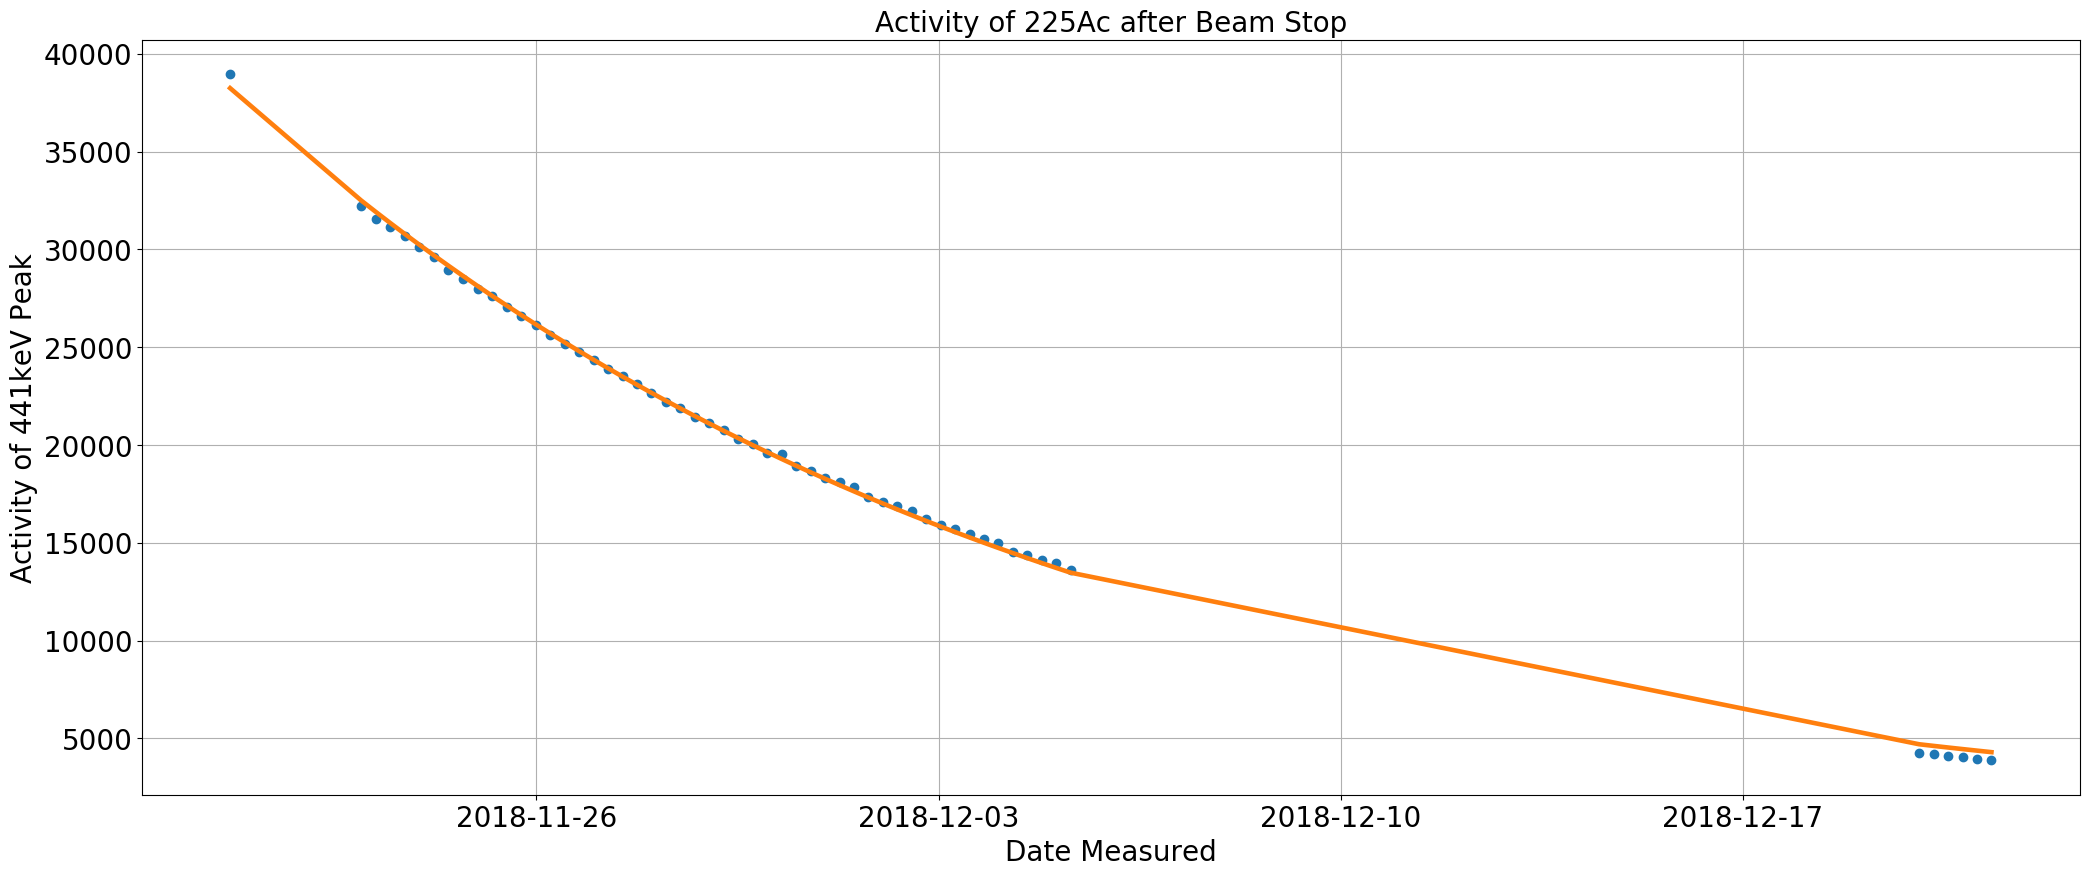

In [61]:
#plotting Ac225 production and Decay, determining curve based on sum of logs
fig=plt.figure(figsize=(25,10),dpi=100)
sortedAcCalculations=AcCalculations1.sort_values(by=['measurementDatetime'])
ax = fig.add_subplot(1, 1, 1)


x = np.array(sortedAcCalculations['measurementDatetime'].to_frame())
y = np.array(sortedAcCalculations['ActivityAtCount'].to_frame())
xelapsed=np.array(sortedAcCalculations['TimeFromSeparation'].to_frame())

guess_a, guess_b = 1000000, -0.0000008022
guess = [guess_a, guess_b]

plt.plot_date(x,y)
fit_params, pcov = scipy.optimize.curve_fit(activityNopt, xelapsed.ravel(), y.ravel(),p0=guess)
y_fit = activityNopt(xelapsed, *fit_params)
plt.plot(x, y_fit, linewidth=3.3)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
     ax.get_xticklabels() + ax.get_yticklabels()):
     item.set_fontsize(20)
ax.grid(which='both')
plt.xlabel('Date Measured')
plt.ylabel('Activity of 441keV Peak')
plt.title('Activity of 225Ac after Beam Stop',fontsize=20)
print('A0='+str(fit_params[0]) +'\n\lambda='+str(fit_params[1]))


